# Simulation of HPL on Dahu

In [1]:
import io
import zipfile
import os
import pandas
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import yaml
import warnings
warnings.simplefilter(action='ignore')

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

def get_platform(archive_name):
    info = get_yaml(archive_name, 'info.yaml')
    expfiles = info['expfile']
    platform = [f for f in expfiles if f.endswith('xml')]
    assert len(platform) == 1
    return platform[0]

def read_csv(archive_name, file_name):
    archive = zipfile.ZipFile(archive_name)
    res = pandas.read_csv(io.BytesIO(archive.read(file_name)))
    res['filename'] = archive_name
    return res

def read_result(name):
    res = read_csv(name, 'results.csv')
    res['start_timestamp'] = pandas.to_datetime(res['start_timestamp'])
    res['start'] = res['start_timestamp'] - res['start_timestamp'].min()
    return res

def read_sim_result(name):
    archive = zipfile.ZipFile(name)
    result = pandas.read_csv(io.BytesIO(archive.read('results.csv')))
    result['platform'] = get_platform(name)
    result['filename'] = name
    info = get_yaml(name, 'info.yaml')
    installfile = info['installfile']
    result['model'] = installfile[8:10]  # filename of the form 'install_A1.yaml', so we get the 'A1'
    return result

simulation_dir = 'factor_exp/2/'
simulation_files = [os.path.join(simulation_dir, f) for f in os.listdir(simulation_dir) if f.endswith('.zip')]
reality_dir = '../hpl/factor_exp/2'
reality_files = [os.path.join(reality_dir, f) for f in os.listdir(reality_dir)]

dfsim = pandas.concat([read_sim_result(f) for f in simulation_files])
dfsim['mode'] = 'Simulation'

dfreal = pandas.concat([read_result(f) for f in reality_files])
dfreal['mode'] = 'Reality'

df = pandas.concat([dfsim, dfreal])
sizes = set(dfsim.matrix_size) & set(dfreal.matrix_size)
df = df[df.matrix_size.isin(sizes)]
df.head()

,application_time,bcast,block_size,cpu_utilization,depth,filename,gflops,major_page_fault,matrix_size,mem_align,...,rfact,simulation_time,start,start_timestamp,stop_timestamp,swap,sys_time,thread_per_process,time,usr_time
0,912.166,0,128,0.99,1,factor_exp/2/grenoble_2020-01-17_1909457.zip,21160.0,0.0,250000,8,...,2,6252.20,NaT,NaT,NaN,1,419.18,1,492.21,5822.20
0,894.091,1,128,0.99,0,factor_exp/2/grenoble_2020-01-17_1909456.zip,25240.0,0.0,250000,8,...,2,7060.66,NaT,NaT,NaN,1,402.72,1,412.72,6644.06
0,798.716,0,256,0.99,0,factor_exp/2/grenoble_2020-01-16_1909236.zip,20890.0,0.0,250000,8,...,2,6652.92,NaT,NaT,NaN,0,2037.98,1,498.61,4603.16
1,725.532,2,256,0.99,0,factor_exp/2/grenoble_2020-01-16_1909236.zip,21850.0,0.0,250000,8,...,2,4976.41,NaT,NaT,NaN,2,289.44,1,476.84,4680.52
2,622.450,5,256,0.99,0,factor_exp/2/grenoble_2020-01-16_1909236.zip,21770.0,0.0,250000,8,...,2,2740.30,NaT,NaT,NaN,1,242.34,1,478.40,2496.33


### Checking the parameters

In [2]:
name_exceptions = {'application_time', 'simulation_time', 'usr_time', 'sys_time', 'time', 'gflops', 'residual', 'cpu_utilization',
                   'dgemm_coefficient', 'dgemm_intercept', 'dtrsm_coefficient', 'dtrsm_intercept',
                   'stochastic_cpu', 'polynomial_dgemm', 'stochastic_network', 'heterogeneous_dgemm', 'platform', 'model', 'filename',
                   'simulation', 'slow_nodes',
                   'major_page_fault', 'minor_page_fault', 'matrix_size', 'mode',
                   'start_timestamp', 'stop_timestamp'}
colnames = set(df) - name_exceptions
df[list(colnames)].drop_duplicates()

,pfact,swap,proc_q,depth,block_size,mem_align,thread_per_process,start,rfact,proc_p,bcast,process_per_node
0,1,1,32,1,128,8,1,NaT,2,32,0,32
0,1,1,32,0,128,8,1,NaT,2,32,1,32
0,1,0,32,0,256,8,1,NaT,2,32,0,32
1,1,2,32,0,256,8,1,NaT,2,32,2,32
2,1,1,32,0,256,8,1,NaT,2,32,5,32
...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,2,32,1,128,8,1,09:00:00.510354,2,32,3,32
68,1,0,32,0,256,8,1,09:08:04.137002,2,32,4,32
69,1,0,32,0,128,8,1,09:17:26.850240,2,32,0,32
70,1,2,32,1,256,8,1,09:24:57.245044,2,32,2,32


In [3]:
from IPython.display import display, Markdown

platforms = [(get_platform(f), zipfile.ZipFile(f).read(get_platform(f)).decode('ascii')) for f in simulation_files]
platforms = list(set(platforms))
assert(len(platforms)) == 1
for name, plat in platforms:
    display(Markdown('### %s' % name))
    display(Markdown('```xml\n%s\n```' % plat))

### dahu.xml

```xml
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.965491847282898e-07:9.63619592297199e-11;8133:4.117386759387727e-06:9.998650637323814e-11;15831:3.901910334928982e-06:1.1003492469181915e-10;33956:8.556208528368661e-06:1.2636592924112397e-10;64000:0.0:0.0"/>
        <prop id="smpi/or" value="0:1.3754300044375236e-06:8.456019002037162e-11;8133:1.0616877366305338e-06:1.0399801951417905e-10;15831:1.1989168715510673e-06:9.880880432093221e-11;33956:1.3028804423006338e-06:1.0742263180618875e-10;64000:0.0:0.0"/>
        <prop id="smpi/ois" value="0:6.931229521083401e-07:7.051204536228214e-11;8133:3.601990790153244e-07:1.2449128895712037e-10;15831:2.97701688103096e-06:4.1302612649640425e-11;33956:3.133466154066955e-06:3.293458765281899e-11;64000:6.939993663604069e-07:0.0"/>
        <prop id="smpi/bw-factor" value="0:0.4955575510466301;8133:5.649491428460505;15831:5.716405752533658;33956:12.659099698925065;64000:0.9867951082730274"/>
        <prop id="smpi/lat-factor" value="0:1.2162964660682605;8133:19.230103984475342;15831:18.285606440676755;33956:51.6103738900493;64000:129.24904864615127"/>
        <prop id="smpi/async-small-thresh" value="64000"/>
        <prop id="smpi/send-is-detached-thresh" value="64000"/>
        <prop id="smpi/iprobe" value="2.115437983643232e-07"/>
        <prop id="smpi/test" value="8.090518732515405e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="dahu-" suffix=".grid5000.fr" radical="0-31" speed="1" core="32" bw="12.5GBps" lat="0.05us" loopback_bw="18.348422228142745GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

### Checking the patch in the new simulation

In [4]:
patches = set()
for row in dfsim.iterrows():
    filename = row[1].filename
    repos = get_yaml(filename, 'info.yaml')['git_repositories']
    hpl = [repo for repo in repos if repo['path'] == 'hpl-2.2']
    assert len(hpl) == 1
    patches.add(hpl[0]['patch'])
assert len(patches) == 1
display(Markdown('```diff\n%s\n```' % patches.pop()))

```diff

diff --git a/Make.SMPI b/Make.SMPI
index c34be62..a610089 100644
--- a/Make.SMPI
+++ b/Make.SMPI
@@ -68,7 +68,7 @@ ARCH         = $(arch)
 # - HPL Directory Structure / HPL library ------------------------------
 # ----------------------------------------------------------------------
 #
-TOPdir       = /home/tom/Documents/Fac/2017_Stage_LIG/hpl-2.2
+TOPdir=/tmp/hpl-2.2
 INCdir       = $(TOPdir)/include
 BINdir       = $(TOPdir)/bin/$(ARCH)
 LIBdir       = $(TOPdir)/lib/$(ARCH)
@@ -93,9 +93,9 @@ MPlib        =
 # header files,  LAlib  is defined  to be the name of  the library to be
 # used. The variable LAdir is only used for defining LAinc and LAlib.
 #
-LAdir        = /usr/lib
+LAdir        = /tmp/lib
 LAinc        =
-LAlib        = -lblas
+LAlib        = /tmp/lib/libopenblas.so
 #
 # ----------------------------------------------------------------------
 # - F77 / C interface --------------------------------------------------
 

diff --git a/src/auxil/HPL_dlacpy.c b/src/auxil/HPL_dlacpy.c
index 70ccbce..0fd833b 100644
--- a/src/auxil/HPL_dlacpy.c
+++ b/src/auxil/HPL_dlacpy.c
@@ -342,8 +342,6 @@ void HPL_dlacpy
 /*
  * End of HPL_dlacpy
  */
-#else
-   smpi_execute_normal_size(3.871806e-09, 1.328595e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/auxil/HPL_dlatcpy.c b/src/auxil/HPL_dlatcpy.c
index 50d71eb..8bdca86 100644
--- a/src/auxil/HPL_dlatcpy.c
+++ b/src/auxil/HPL_dlatcpy.c
@@ -397,8 +397,6 @@ void HPL_dlatcpy
 /*
  * End of HPL_dlatcpy
  */
-#else
-    smpi_execute_normal_size(4.893900e-09, 4.691039e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp01T.c b/src/pauxil/HPL_dlaswp01T.c
index dc0f8b3..e0d8879 100644
--- a/src/pauxil/HPL_dlaswp01T.c
+++ b/src/pauxil/HPL_dlaswp01T.c
@@ -251,8 +251,6 @@ void HPL_dlaswp01T
 /*
  * End of HPL_dlaswp01T
  */
-#else
-    smpi_execute_normal_size(7.547639e-09, 1.371708e-09, ((double)M)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp02N.c b/src/pauxil/HPL_dlaswp02N.c
index ba461fc..d7345d9 100644
--- a/src/pauxil/HPL_dlaswp02N.c
+++ b/src/pauxil/HPL_dlaswp02N.c
@@ -204,8 +204,6 @@ void HPL_dlaswp02N
 /*
  * End of HPL_dlaswp02N
  */
-#else
-    smpi_execute_normal_size(2.822241e-08, 5.497050e-09, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp03T.c b/src/pauxil/HPL_dlaswp03T.c
index 8e54bfe..92c4665 100644
--- a/src/pauxil/HPL_dlaswp03T.c
+++ b/src/pauxil/HPL_dlaswp03T.c
@@ -185,8 +185,6 @@ void HPL_dlaswp03T
 /*
  * End of HPL_dlaswp03T
  */
-#else
-    smpi_execute_normal_size(3.775240e-09, 2.968320e-10, ((double)M)*N);
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 2, (int []){M, N});
diff --git a/src/pauxil/HPL_dlaswp04T.c b/src/pauxil/HPL_dlaswp04T.c
index 61dd638..8e05cf3 100644
--- a/src/pauxil/HPL_dlaswp04T.c
+++ b/src/pauxil/HPL_dlaswp04T.c
@@ -269,8 +269,6 @@ void HPL_dlaswp04T
 /*
  * End of HPL_dlaswp04T
  */
-#else
-   smpi_execute_normal_size(8.498957e-09, 2.218070e-09, ((double)M1)*((double)N));
 #endif // SMPI_OPTIMIZATION_LEVEL
     timestamp_t duration = get_timestamp() - start;
     record_measure("", 0, __func__, start, duration, 3, (int []){M0, M1, N});
    

diff --git a/src/blas/HPL_dgemm.c b/src/blas/HPL_dgemm.c
index dd235b7..ab40276 100644
--- a/src/blas/HPL_dgemm.c
+++ b/src/blas/HPL_dgemm.c
@@ -204,14 +204,14 @@ double random_halfnormal_shifted(double exp, double std) {
 }

 void smpi_execute_normal(double mu, double sigma) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0) {
         smpi_execute_benched(coefficient);
     }
 }

 void smpi_execute_normal_size(double mu, double sigma, double size) {
-    double coefficient = random_halfnormal_shifted(mu, sigma);
+    double coefficient = mu;
     if(coefficient > 0 && size > 0) {
         smpi_execute_benched(size * coefficient);
     }
    
```

### Checking that the real run has no temporal pattern

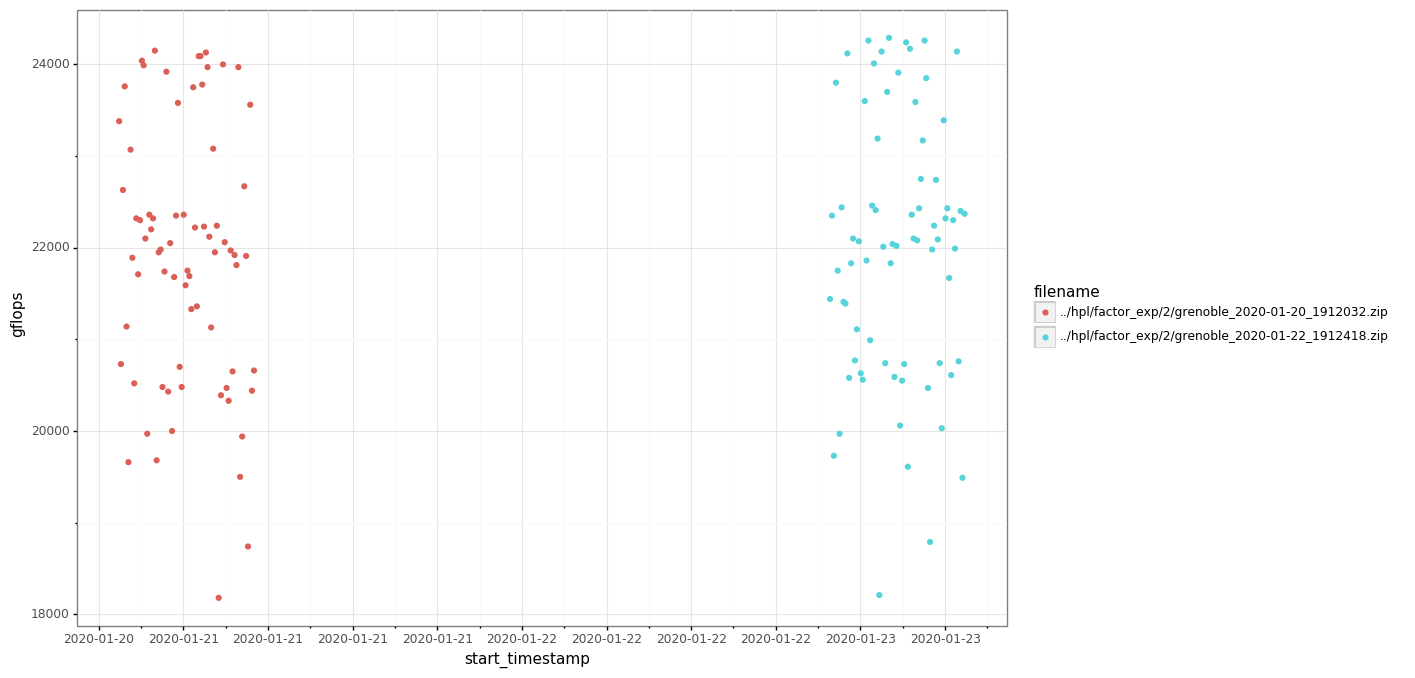

<ggplot: (8782806189751)>

In [5]:
ggplot(dfreal, aes(x='start_timestamp', y='gflops', color='filename')) + geom_point() + theme_bw()

### Prediction error for individual factor combinations

In [6]:
factors = ['swap', 'bcast', 'depth', 'block_size']

In [7]:
grouped_real = dfreal.groupby(factors)[['gflops']].mean()
comparison = grouped_real.join(dfsim.set_index(factors), how='outer', lsuffix='_reality', rsuffix='_simulation').reset_index()
comparison['error'] = (comparison['gflops_simulation'] - comparison['gflops_reality'])/comparison['gflops_reality'] * 100
comparison['error'].describe()

count    72.000000
mean     -0.279452
std       4.463210
min     -16.276803
25%      -1.956466
50%       0.346254
75%       3.180818
max       5.647701
Name: error, dtype: float64

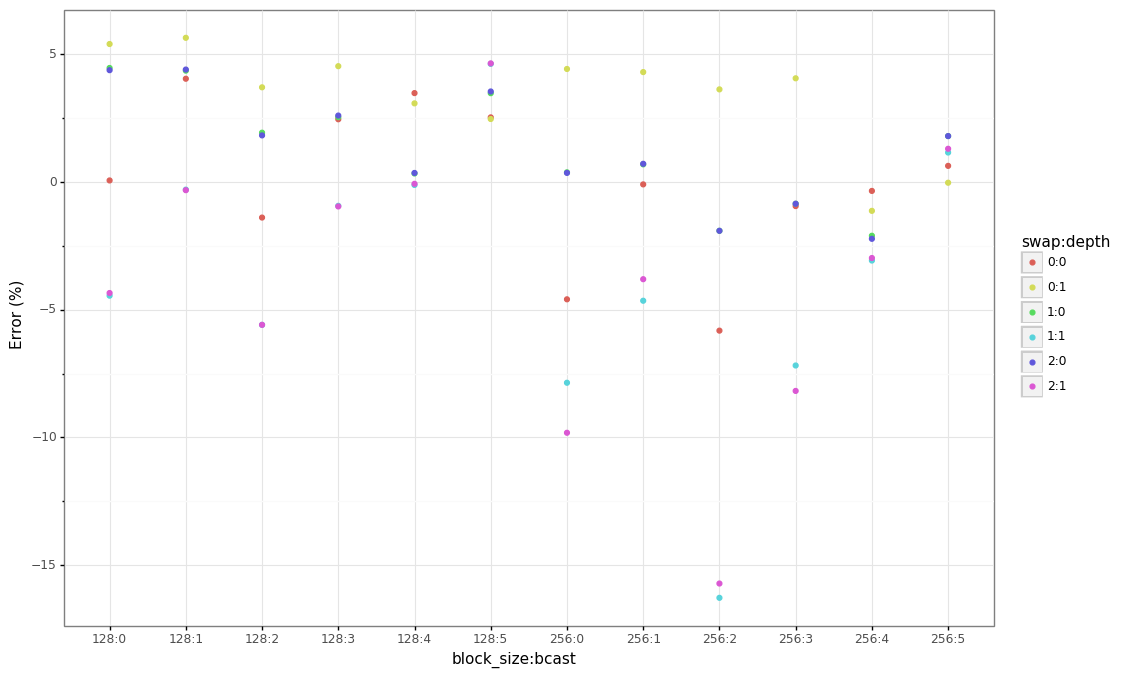

<ggplot: (8782798946410)>

In [8]:
def do_plot(df, y, x_factors, x_colors, jitter=False):
    tmp = df.copy()
    xfact = ':'.join(x_factors)
    xcol = ':'.join(x_colors)
    tmp[xfact] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_factors), axis=1)
    tmp[xcol] = tmp.apply(lambda row: ':'.join(str(row[fact]) for fact in x_colors), axis=1)
    plot = ggplot(tmp, aes(x=xfact, y=y, color=xcol)) + theme_bw()
    if jitter:
        plot += geom_jitter()
    else:
        plot += geom_point()
    return plot

do_plot(comparison, 'error', ['block_size', 'bcast'], ['swap', 'depth']) + ylab('Error (%)')

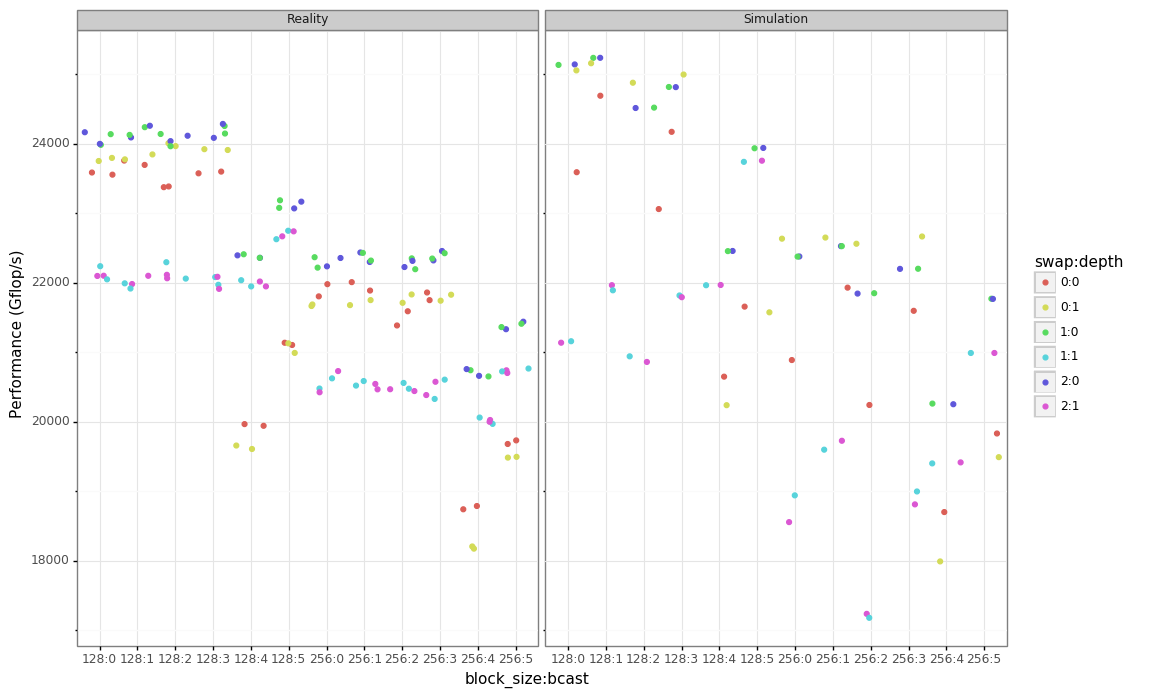

<ggplot: (-9223363254055628235)>

In [9]:
do_plot(df, 'gflops', ['block_size', 'bcast'], ['swap', 'depth'], jitter=True) + ylab('Performance (Gflop/s)') + facet_wrap('mode')

### Simulation efficiency

In [10]:
dfsim.simulation_time.describe()

count      72.000000
mean     4999.194444
std      1446.136212
min      2204.360000
25%      4307.682500
50%      4961.145000
75%      6121.682500
max      7850.190000
Name: simulation_time, dtype: float64

In [11]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

def my_anova(df, factors, response, two_way=True):
    f_str = ['C(%s)' % fact for fact in factors if len(df[fact].unique()) > 1]
    formula = ' + '.join(f_str)
    if two_way:
        formula = '(%s)**2' % formula
    formula = '%s ~ %s' % (response, formula)
    print(formula)
    model = ols(formula, df).fit()
    aov_table = anova_lm(model, typ=2)
    aov_table['stars'] = ''
    aov_table.loc[aov_table['PR(>F)'] < 0.1 ,  'stars'] = '.'
    aov_table.loc[aov_table['PR(>F)'] < 0.05,  'stars'] = '*'
    aov_table.loc[aov_table['PR(>F)'] < 0.01,  'stars'] = '**'
    aov_table.loc[aov_table['PR(>F)'] < 0.001, 'stars'] = '***'
    return aov_table

In [12]:
my_anova(dfsim, factors, 'simulation_time').sort_values(by='F', ascending=False)

simulation_time ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(block_size),3.876765e+07,1.0,295.209314,3.197233e-19,***
C(bcast),6.330540e+07,5.0,96.412053,3.582754e-20,***
C(depth),1.140418e+07,1.0,86.840965,3.027532e-11,***
C(swap):C(block_size),6.100627e+06,2.0,23.227639,2.916329e-07,***
C(swap),4.384918e+06,2.0,16.695217,6.803453e-06,***
C(bcast):C(depth),7.423729e+06,5.0,11.306097,1.154463e-06,***
C(swap):C(bcast),1.028255e+07,10.0,7.829996,1.395610e-06,***
C(bcast):C(block_size),1.754231e+06,5.0,2.671636,3.692378e-02,*
C(depth):C(block_size),9.909113e+04,1.0,0.754563,3.906353e-01,
C(swap):C(depth),1.016843e+05,2.0,0.387155,6.817043e-01,


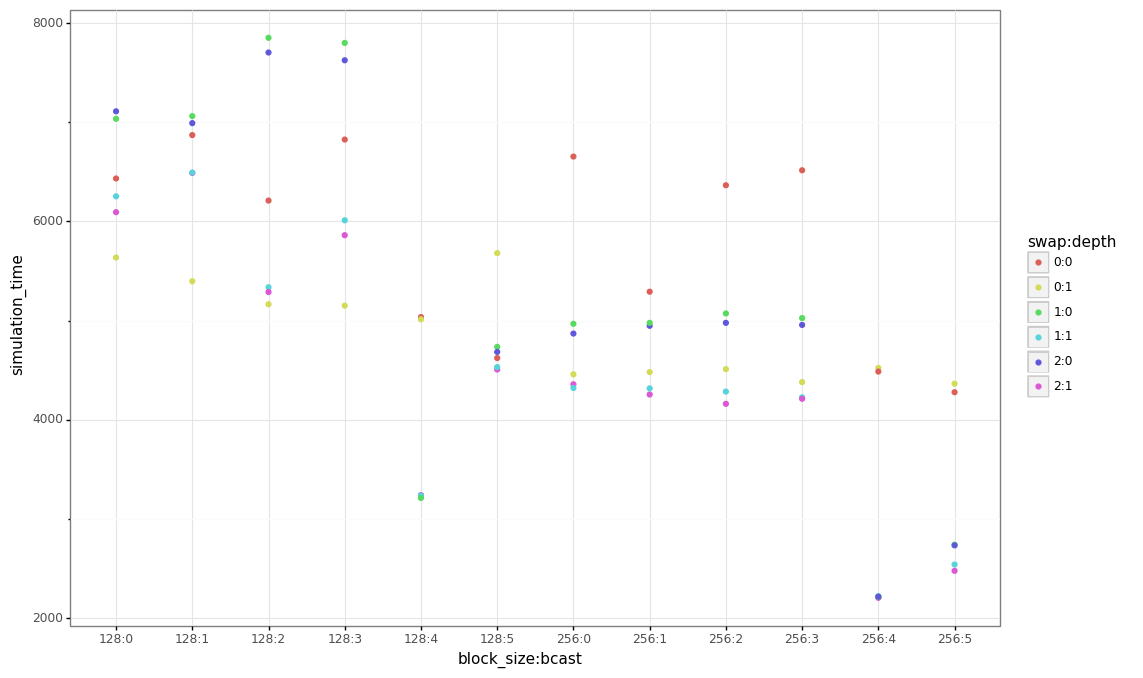

<ggplot: (8782799044605)>

In [13]:
do_plot(dfsim, 'simulation_time', ['block_size', 'bcast'], ['swap', 'depth'])

### Nodes temperature during the real runs

In [14]:
temperatures = pandas.concat([read_csv(f, 'temperatures.csv') for f in reality_files])
temperatures['timestamp'] = pandas.to_datetime(temperatures['timestamp'])
temperatures['node'] = temperatures.hostname.str[len('dahu-'):-len('.grenoble.grid5000.fr')].astype(int)
temperatures['index'] = -1
for filename in temperatures.filename.unique():
    for node in temperatures.node.unique():
        for sensor_id in temperatures.sensor_id.unique():
            temperatures.loc[(temperatures.node == node) & (temperatures.sensor_id == sensor_id) & (temperatures.filename == filename), 'index'] = range(len(temperatures[(temperatures.node == node) & (temperatures.sensor_id == sensor_id)  & (temperatures.filename == filename)]))
temperatures.head()

,timestamp,hostname,temperature,sensor_id,filename,node,index
0,2020-01-22 21:38:28.442954,dahu-1.grenoble.grid5000.fr,50.0,0,../hpl/factor_exp/2/grenoble_2020-01-22_191241...,1,0
1,2020-01-22 21:38:28.442954,dahu-1.grenoble.grid5000.fr,37.0,1,../hpl/factor_exp/2/grenoble_2020-01-22_191241...,1,0
2,2020-01-22 21:38:28.442954,dahu-5.grenoble.grid5000.fr,53.0,0,../hpl/factor_exp/2/grenoble_2020-01-22_191241...,5,0
3,2020-01-22 21:38:28.442954,dahu-5.grenoble.grid5000.fr,39.0,1,../hpl/factor_exp/2/grenoble_2020-01-22_191241...,5,0
4,2020-01-22 21:38:28.442954,dahu-6.grenoble.grid5000.fr,47.0,0,../hpl/factor_exp/2/grenoble_2020-01-22_191241...,6,0


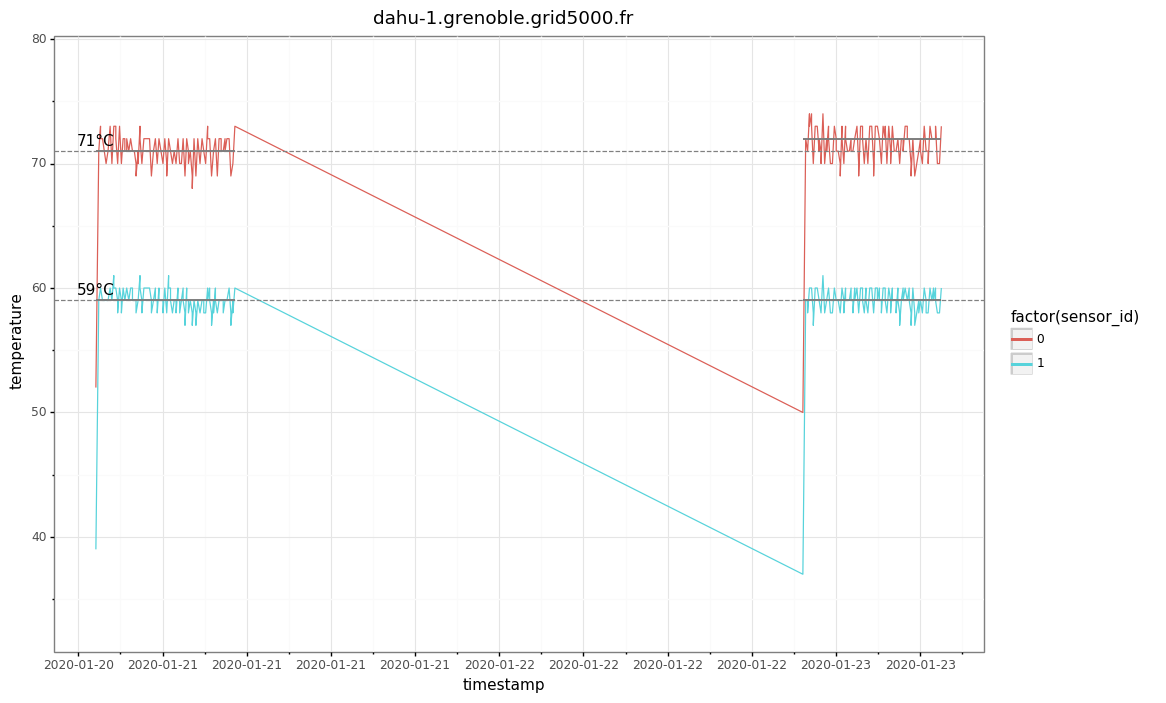

<ggplot: (8782798980065)>


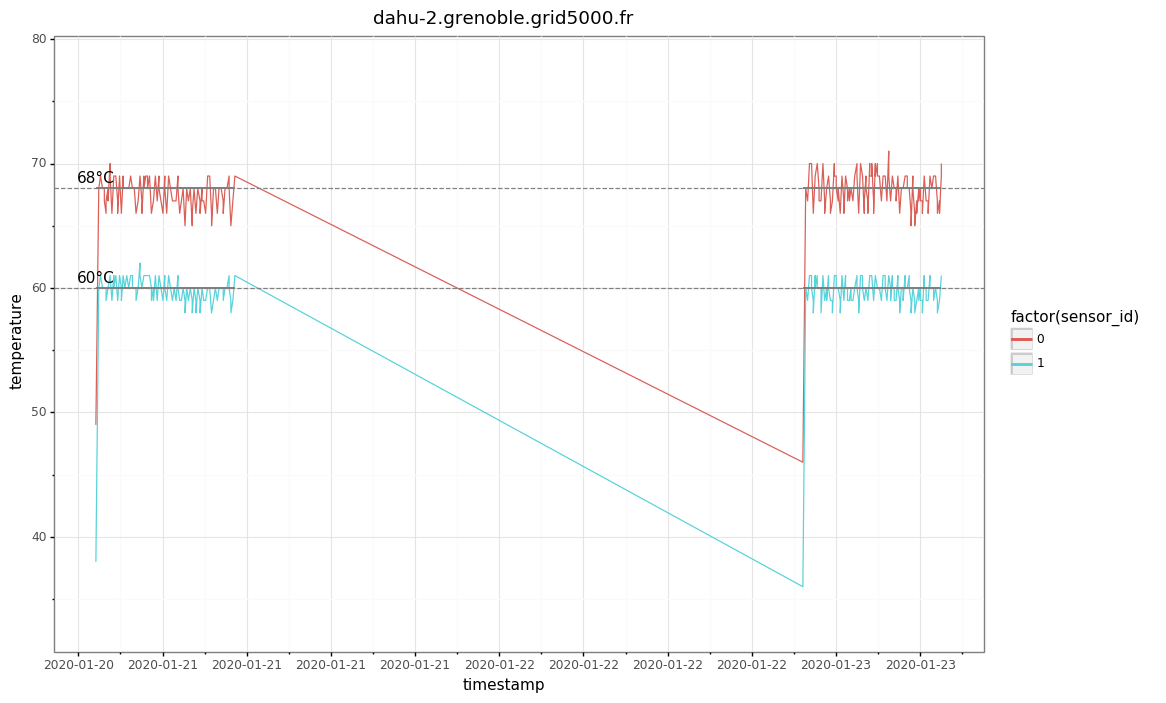

<ggplot: (-9223363254062014043)>


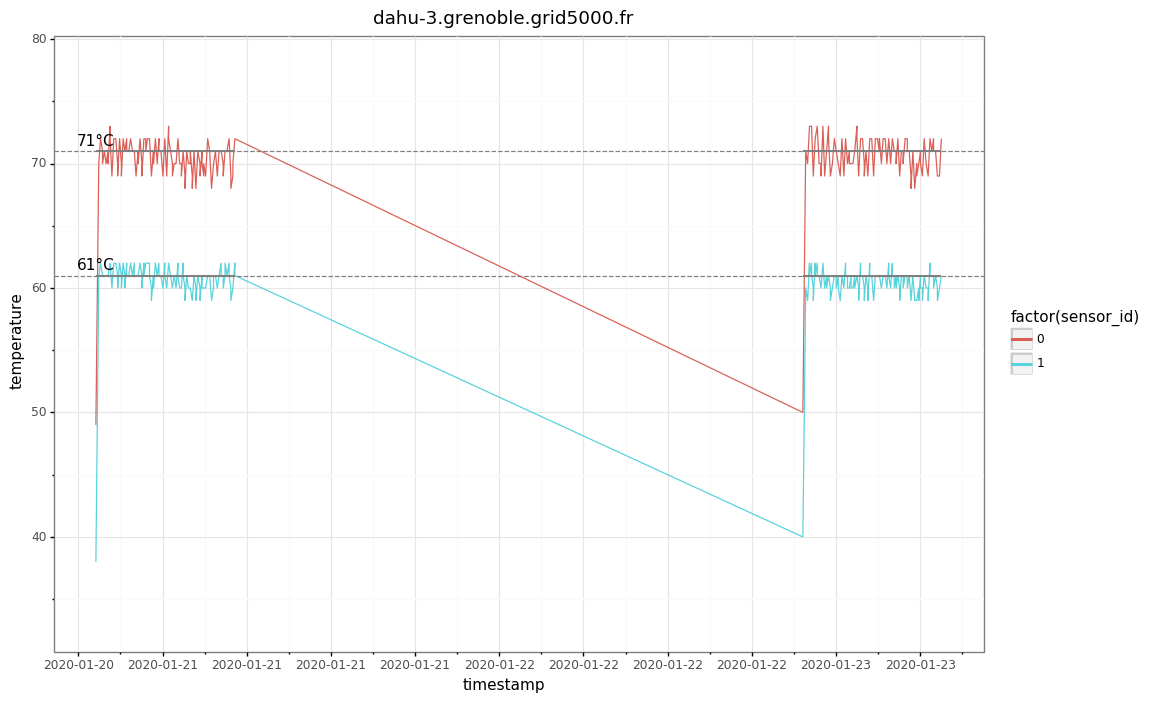

<ggplot: (-9223363254055593251)>


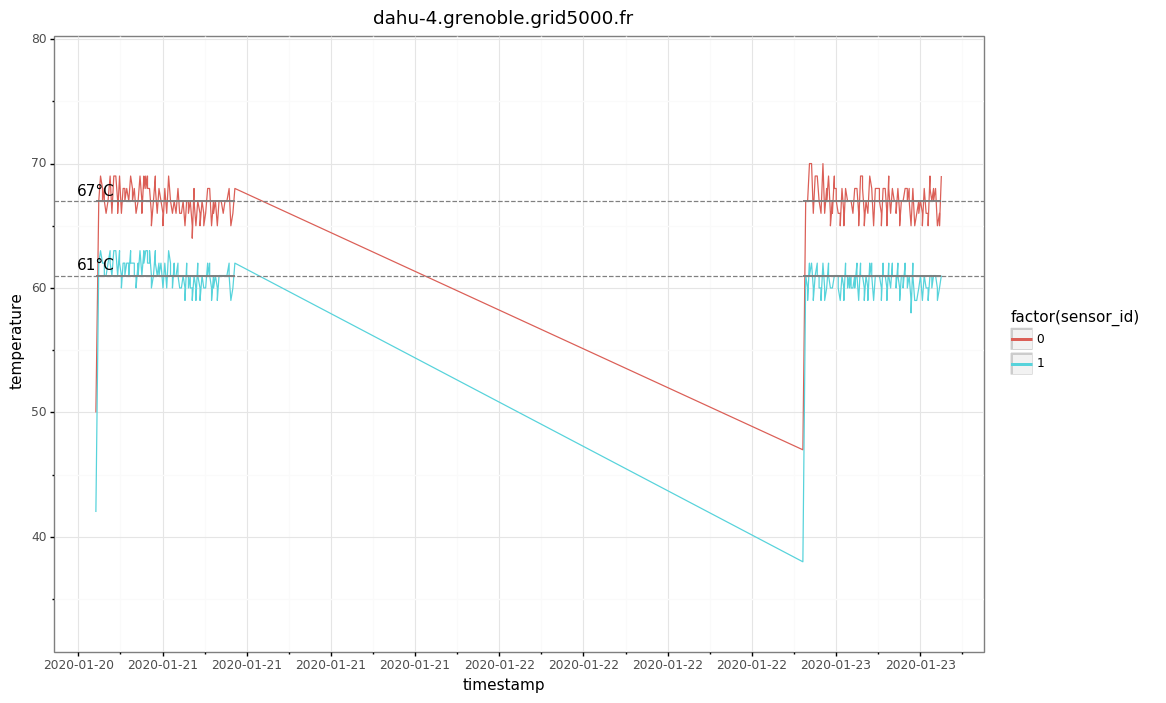

<ggplot: (-9223363254062249756)>


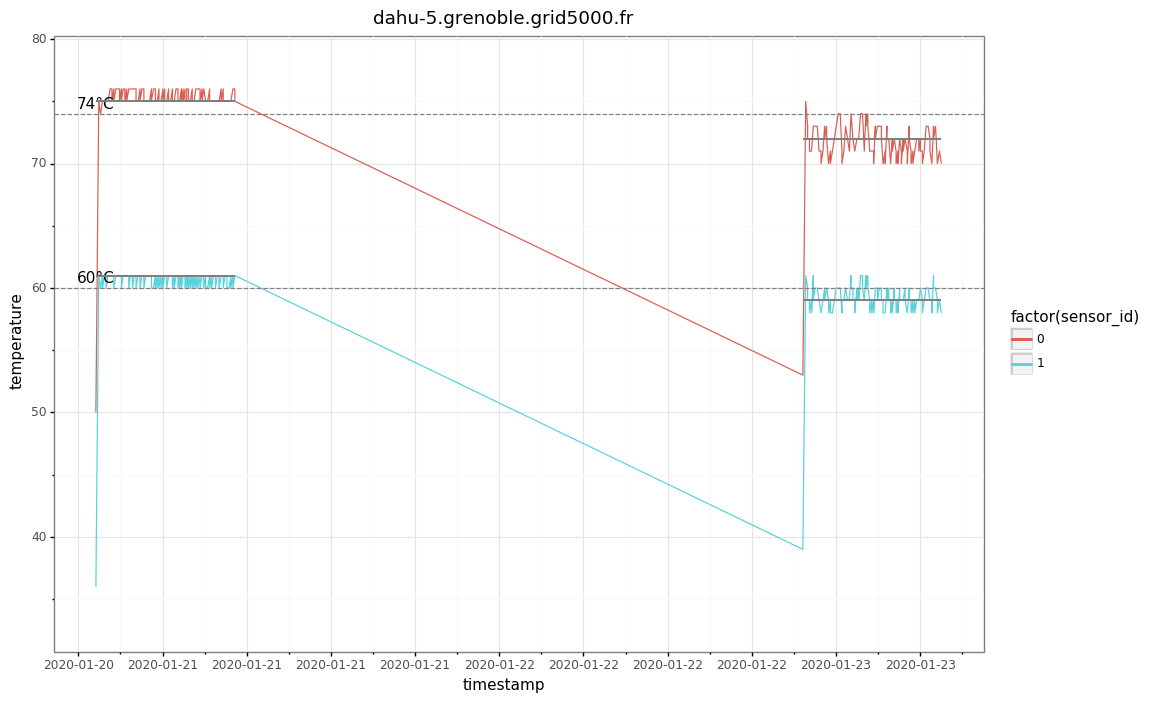

<ggplot: (-9223363254062385611)>


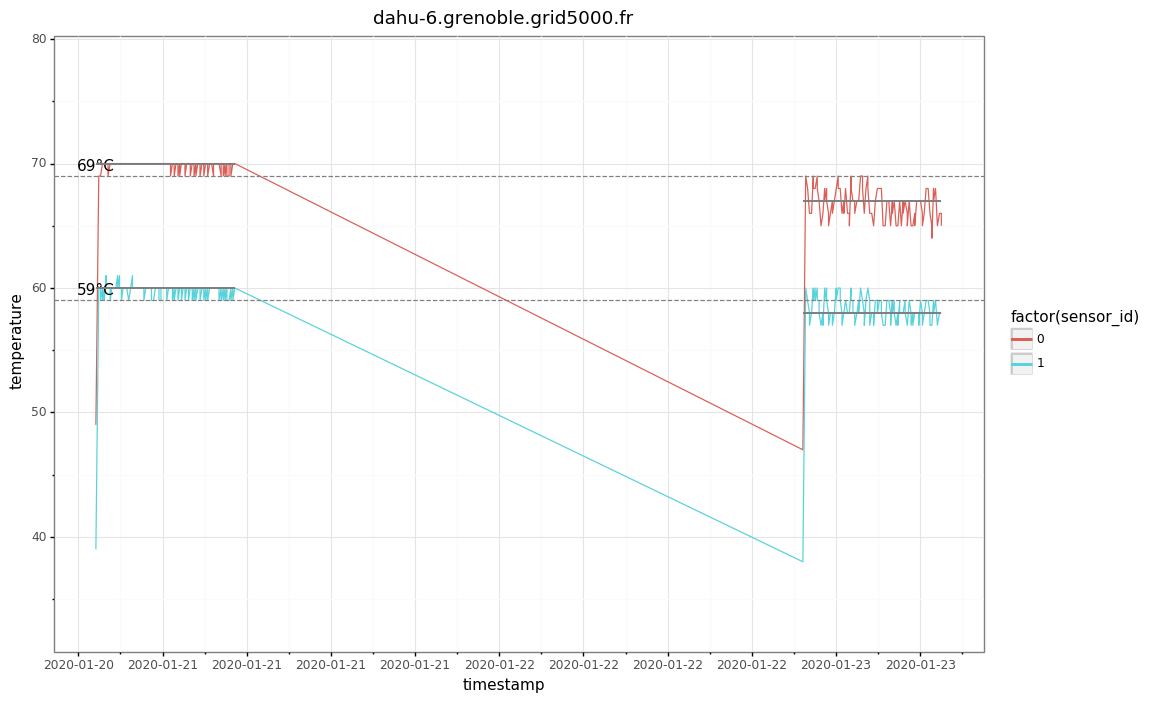

<ggplot: (8782792363542)>


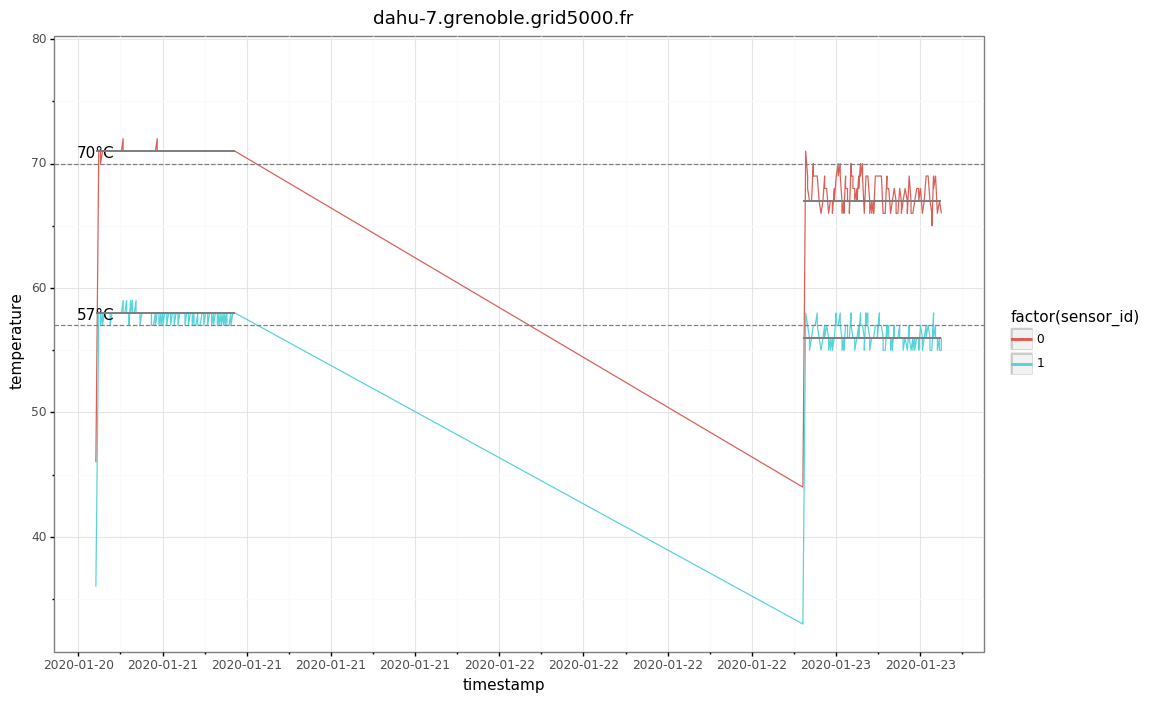

<ggplot: (-9223363254062741546)>


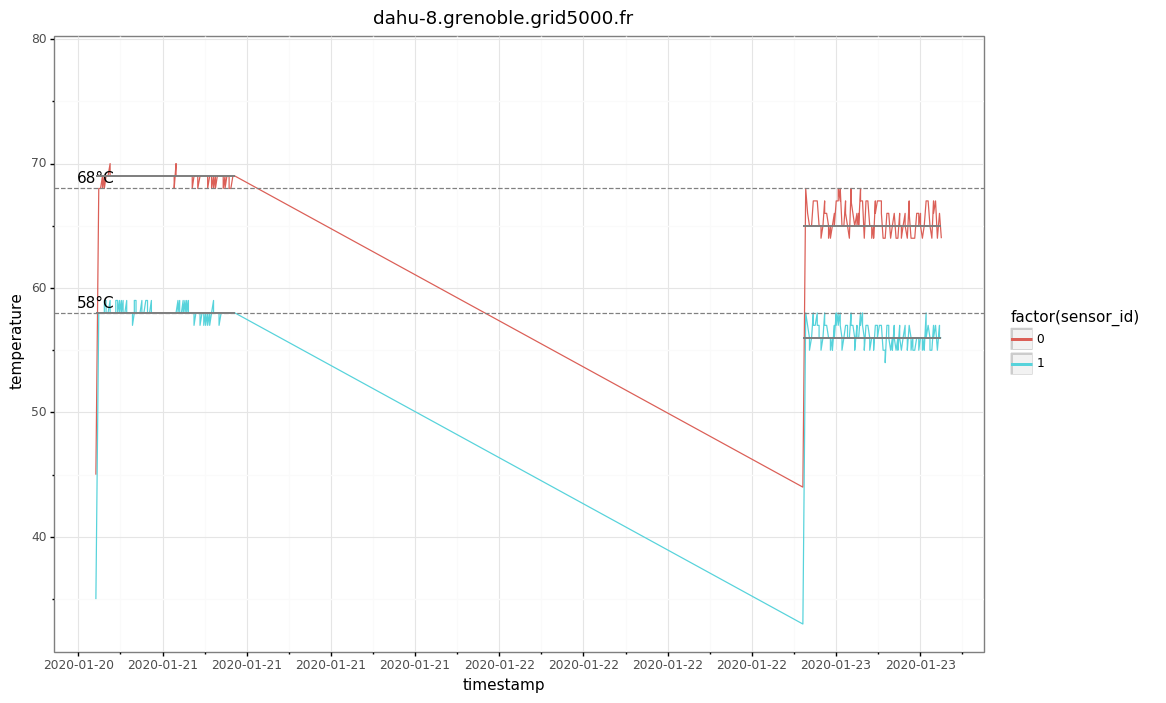

<ggplot: (8782792779847)>


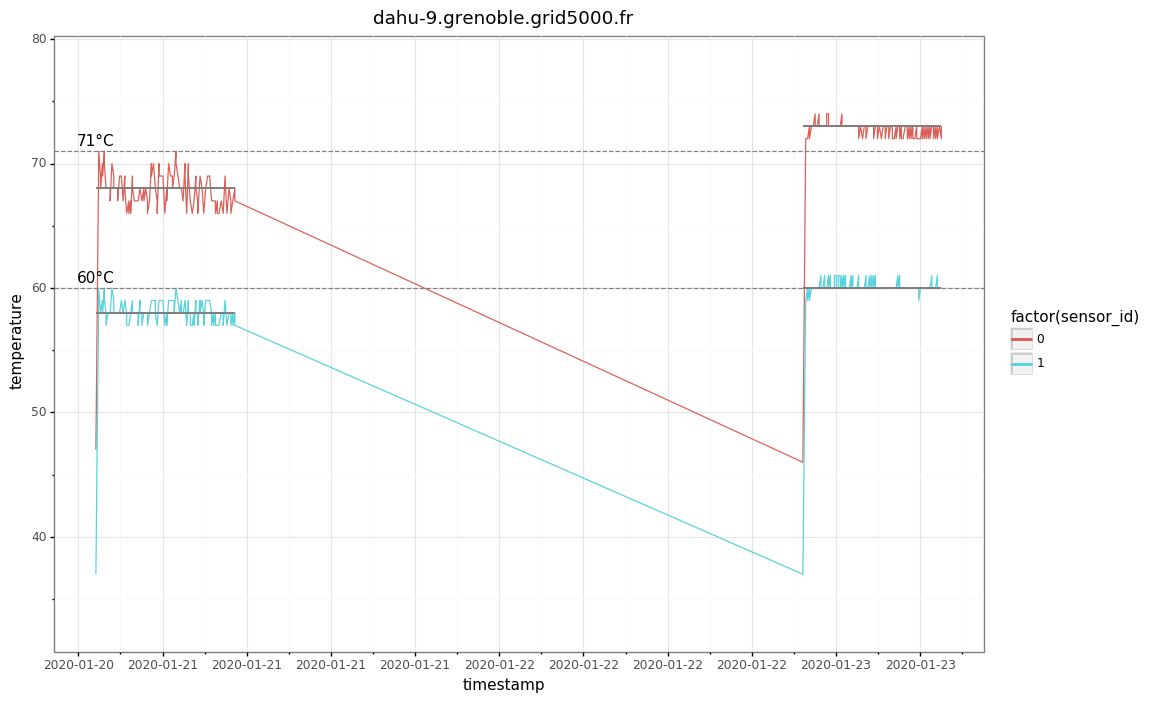

<ggplot: (-9223363254055652990)>


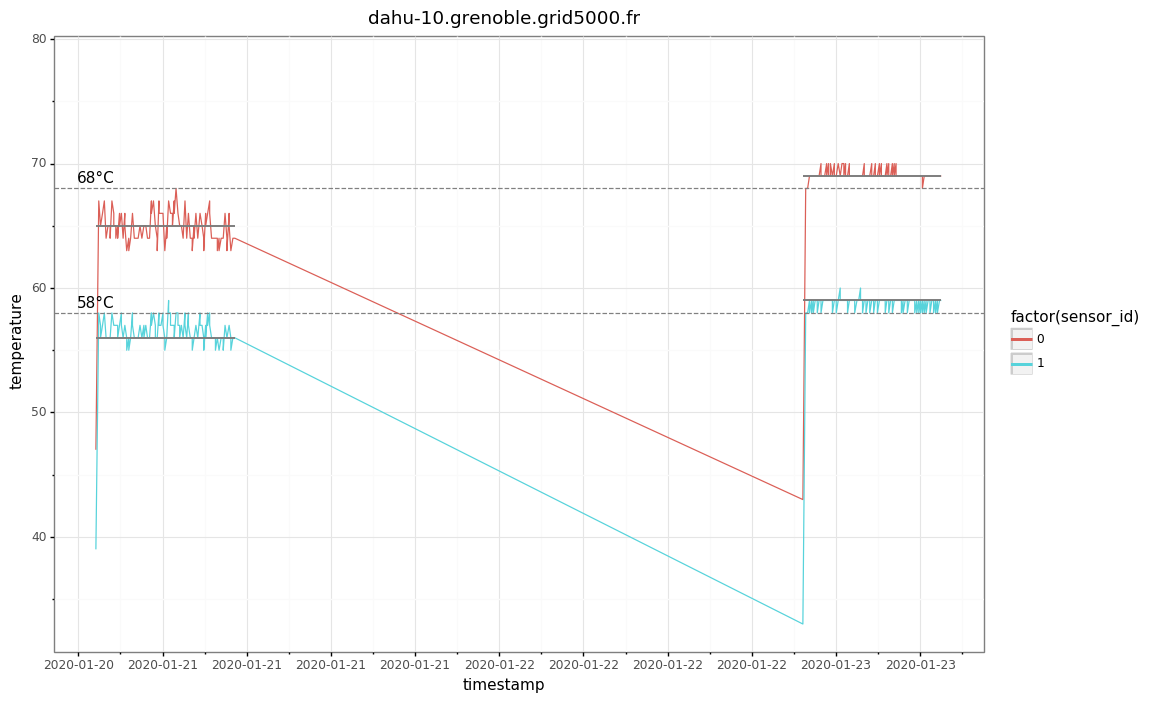

<ggplot: (8782798834429)>


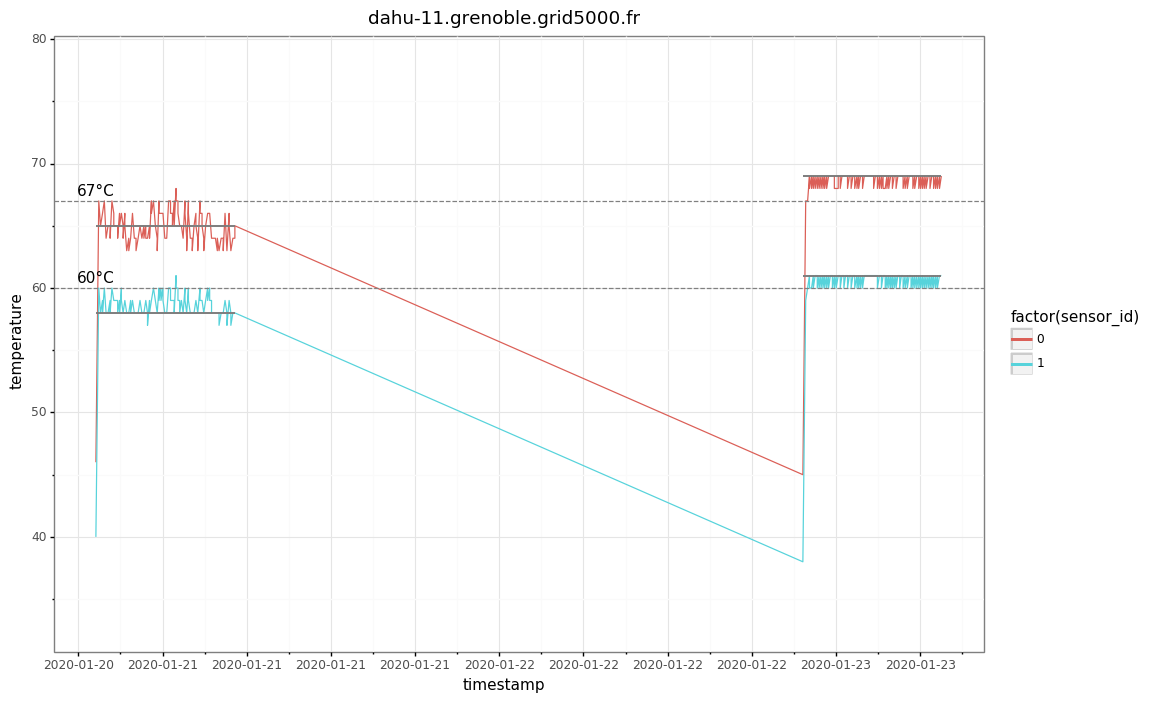

<ggplot: (-9223363254062855175)>


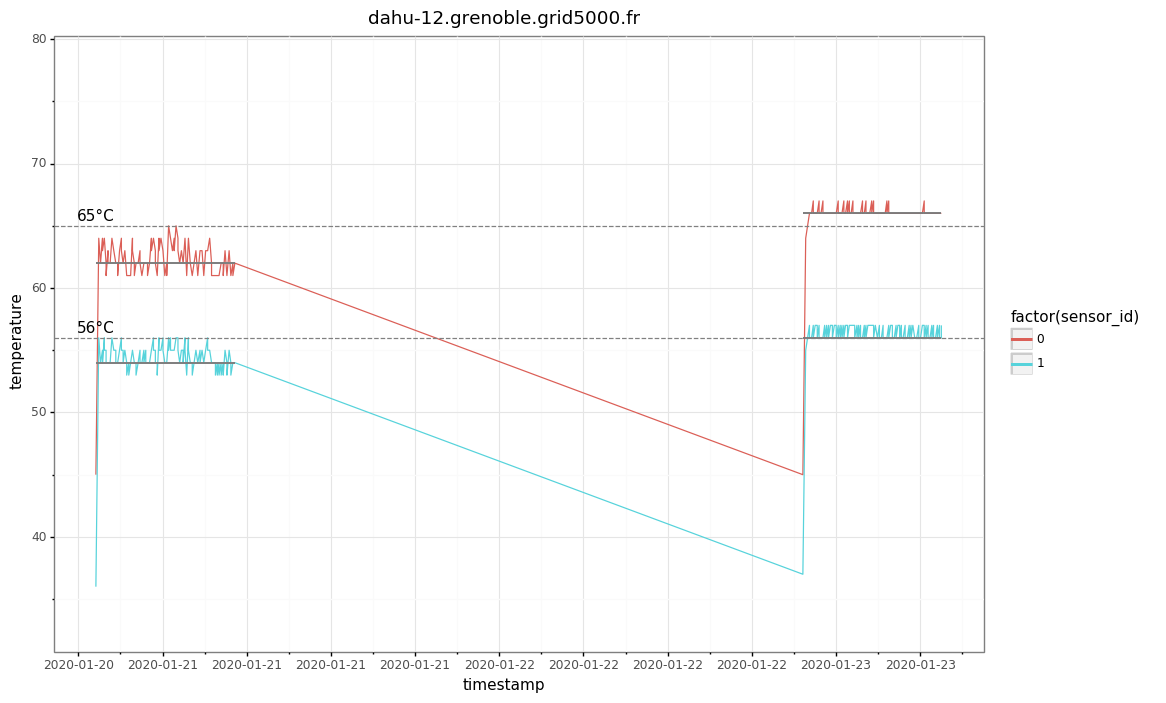

<ggplot: (-9223363254063016967)>


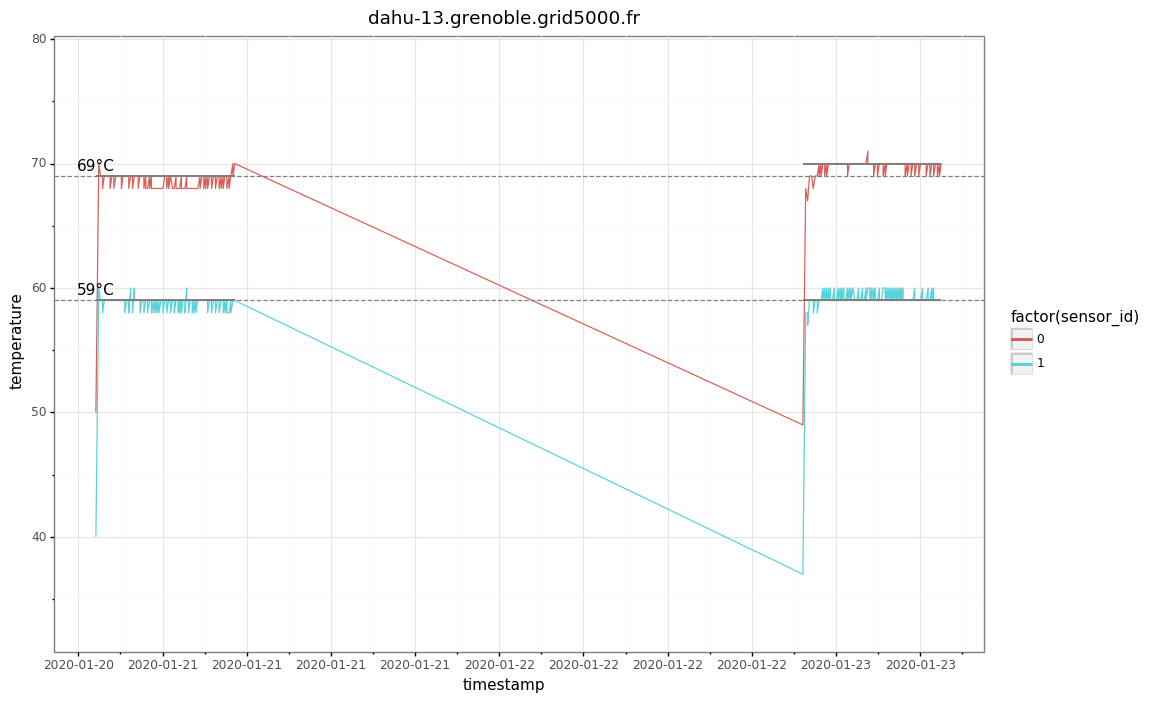

<ggplot: (8782799151133)>


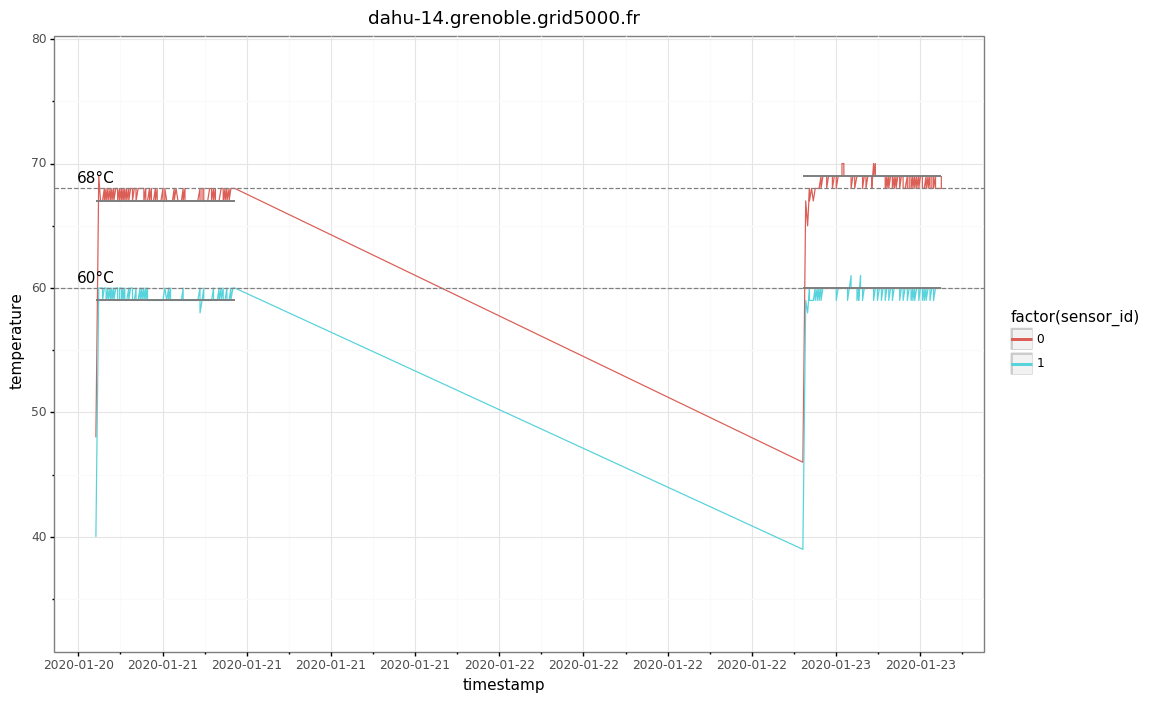

<ggplot: (8782798946084)>


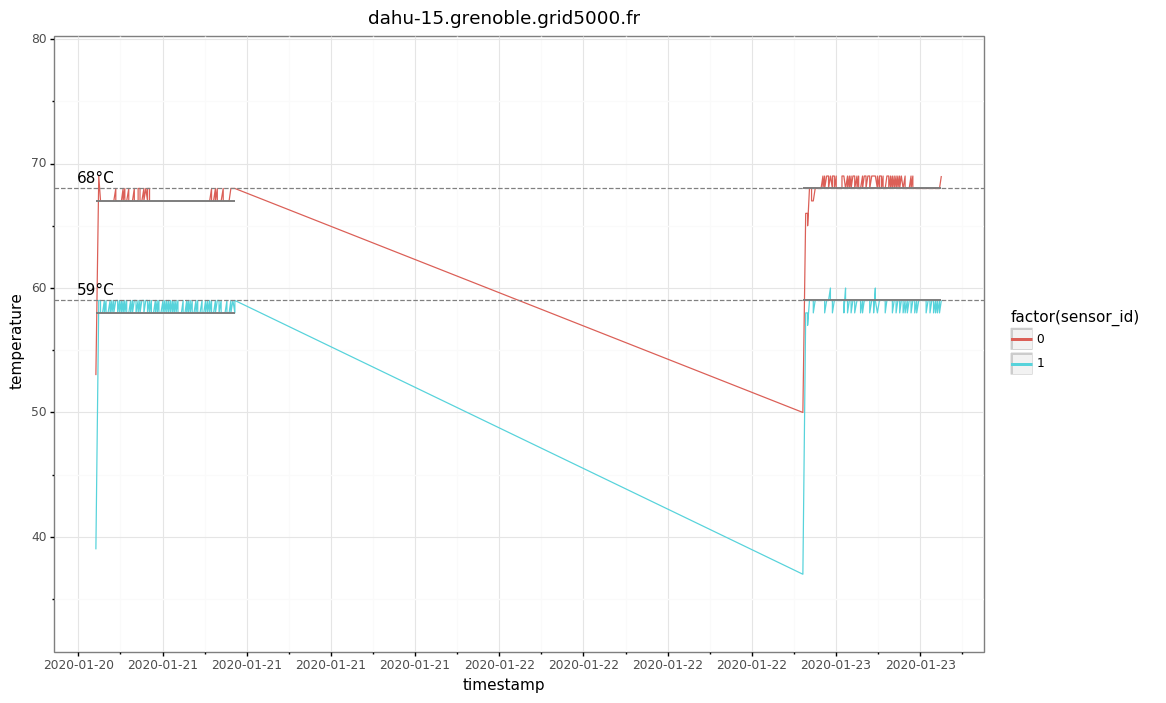

<ggplot: (8782799035263)>


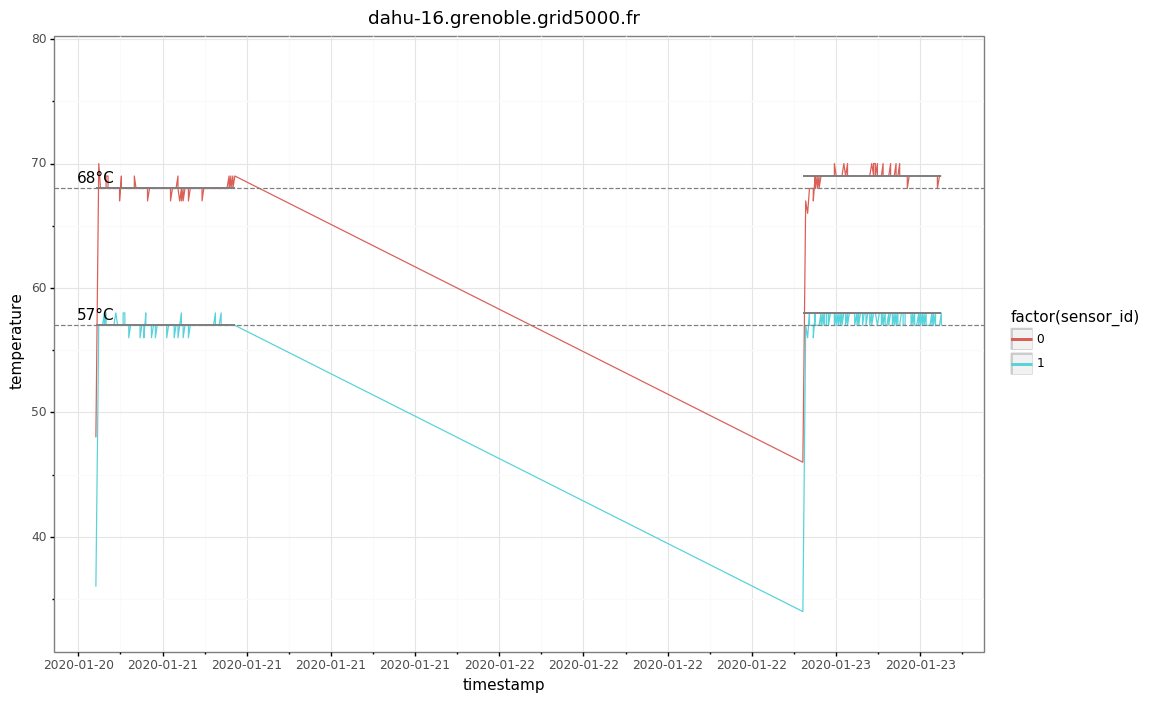

<ggplot: (-9223363254055755495)>


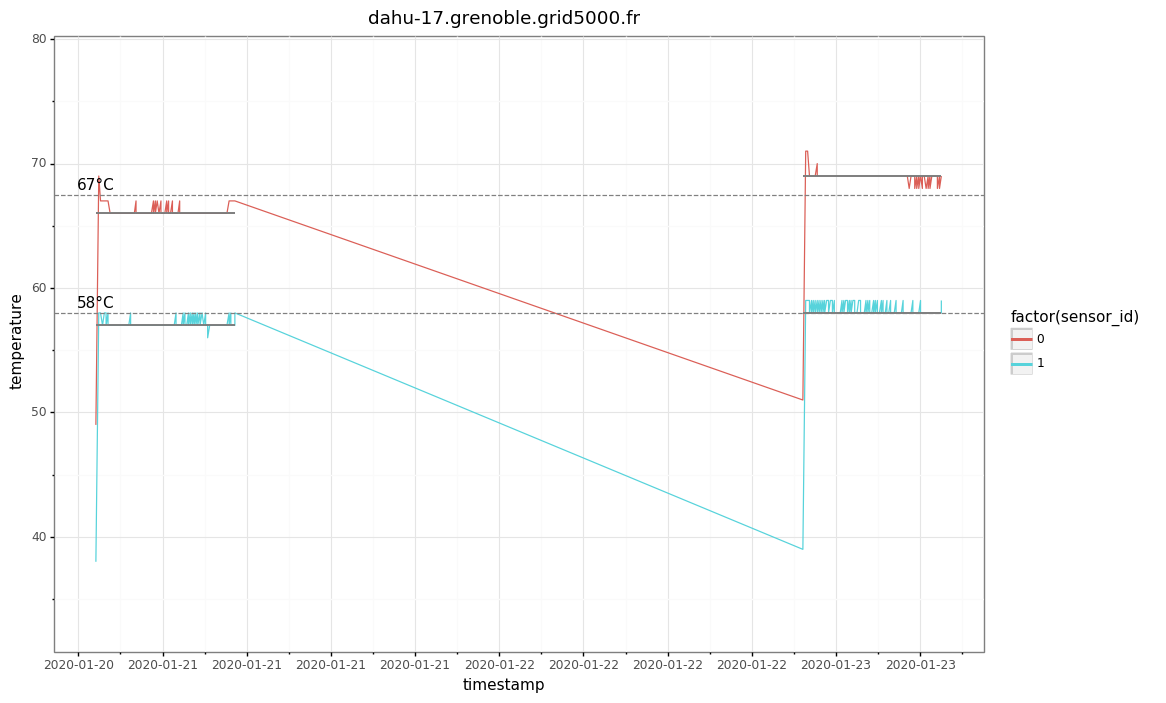

<ggplot: (8782792595176)>


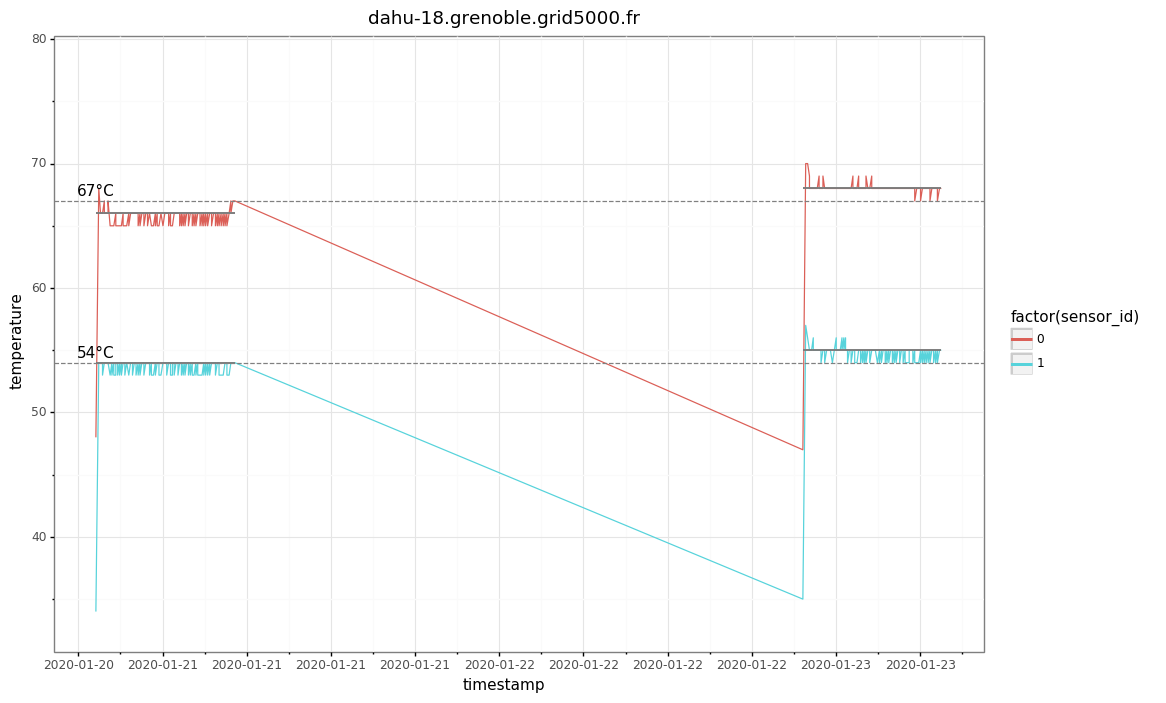

<ggplot: (8782792435874)>


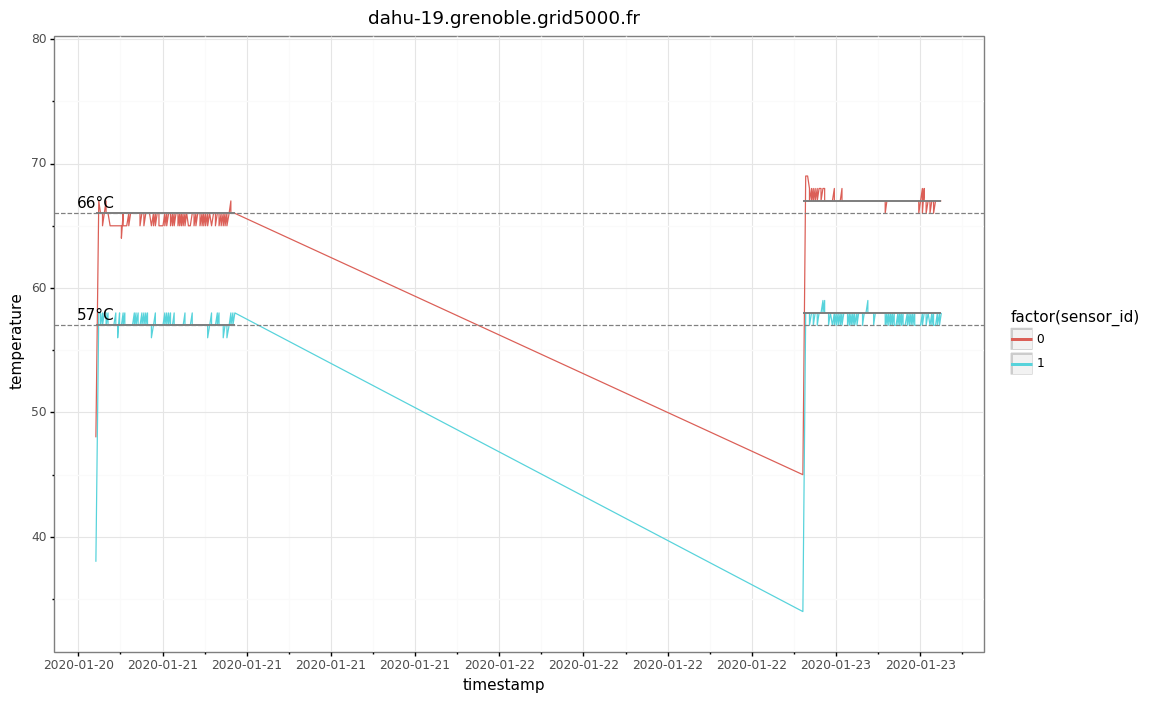

<ggplot: (8782799166472)>


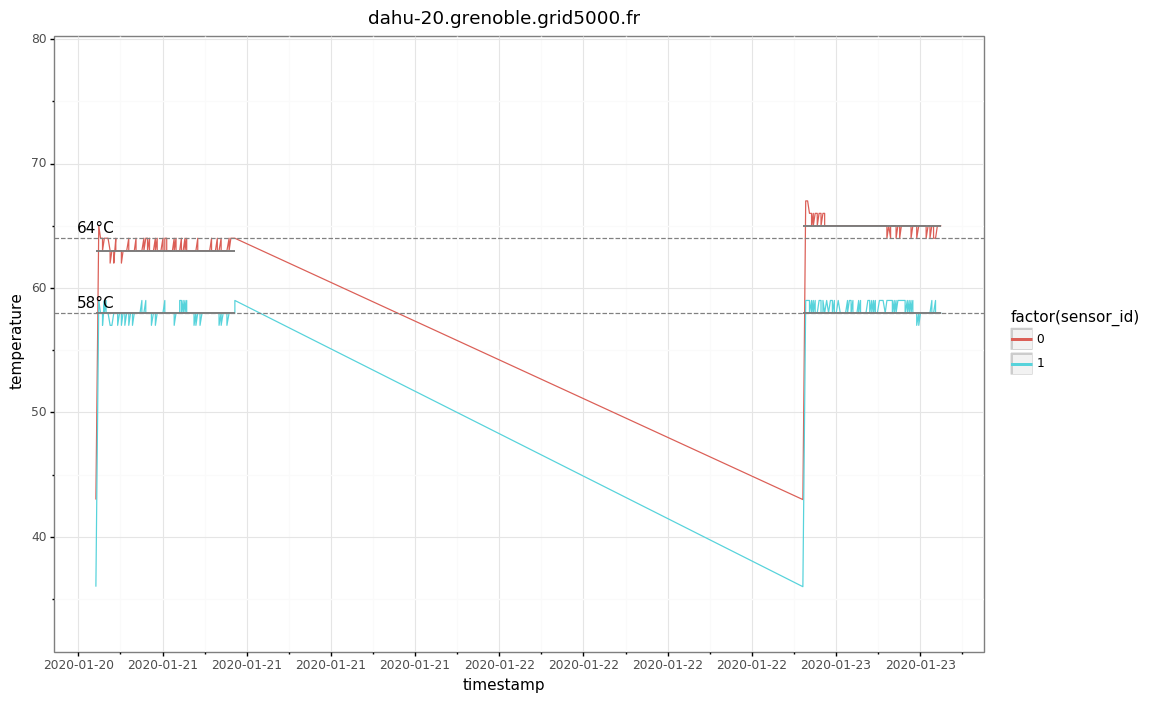

<ggplot: (8782792227767)>


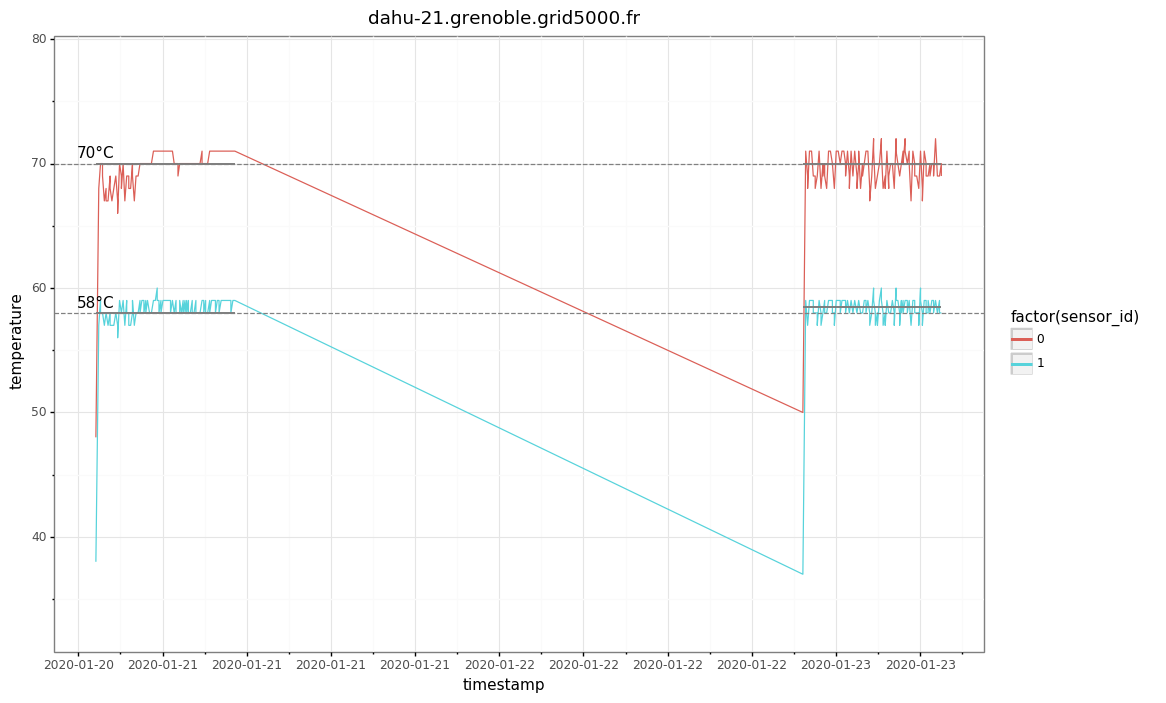

<ggplot: (-9223363254055614611)>


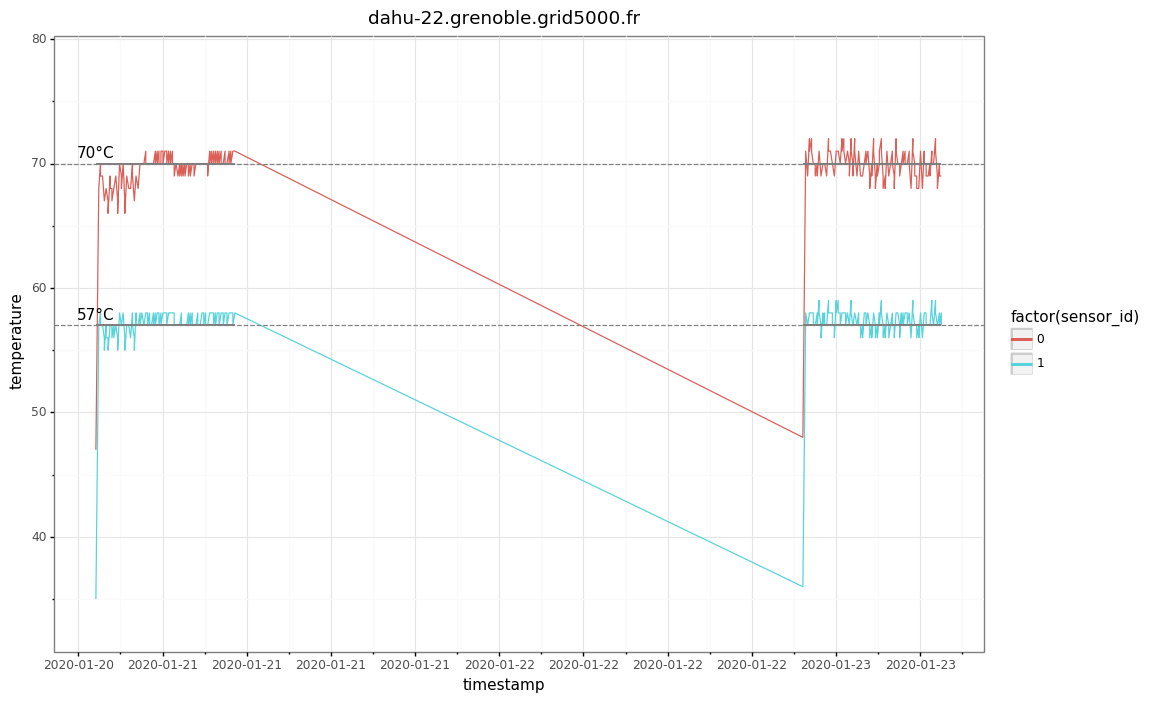

<ggplot: (8782791841277)>


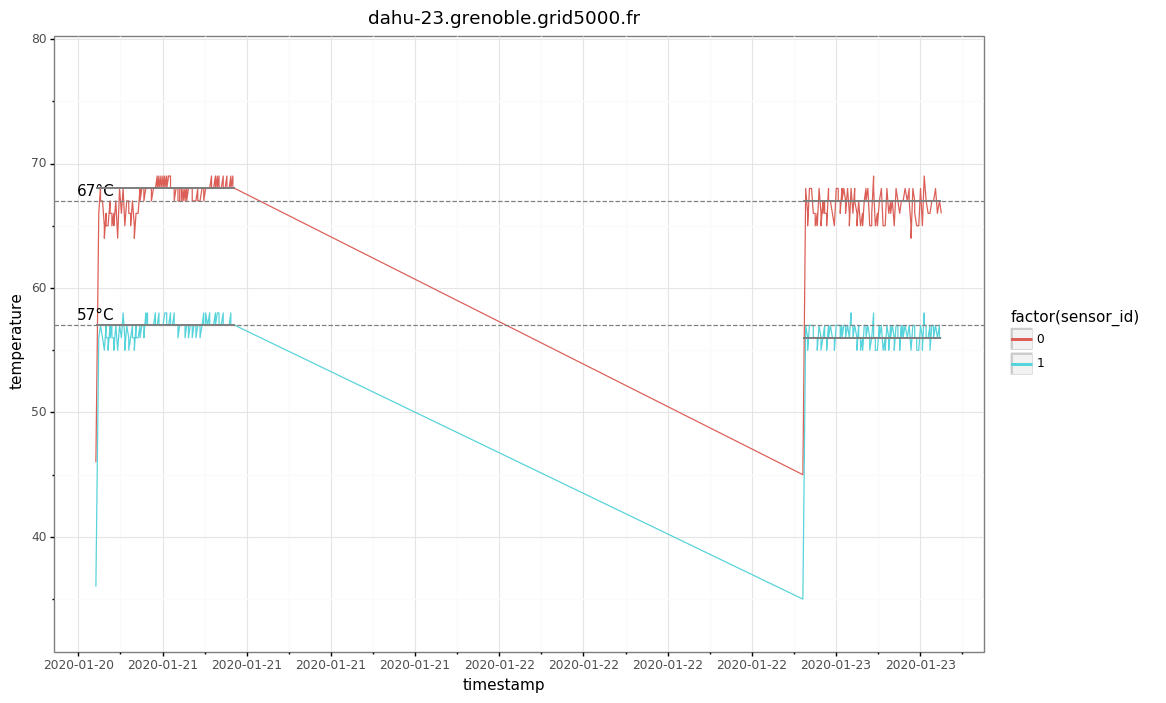

<ggplot: (8782798784141)>


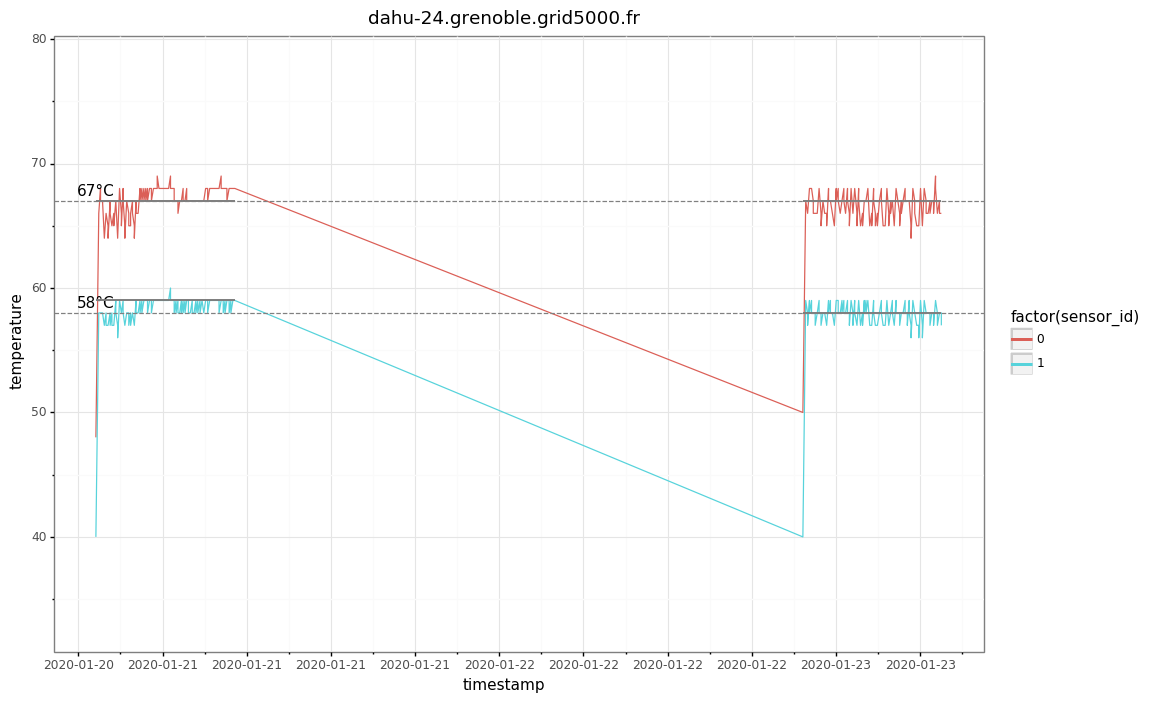

<ggplot: (8782792435944)>


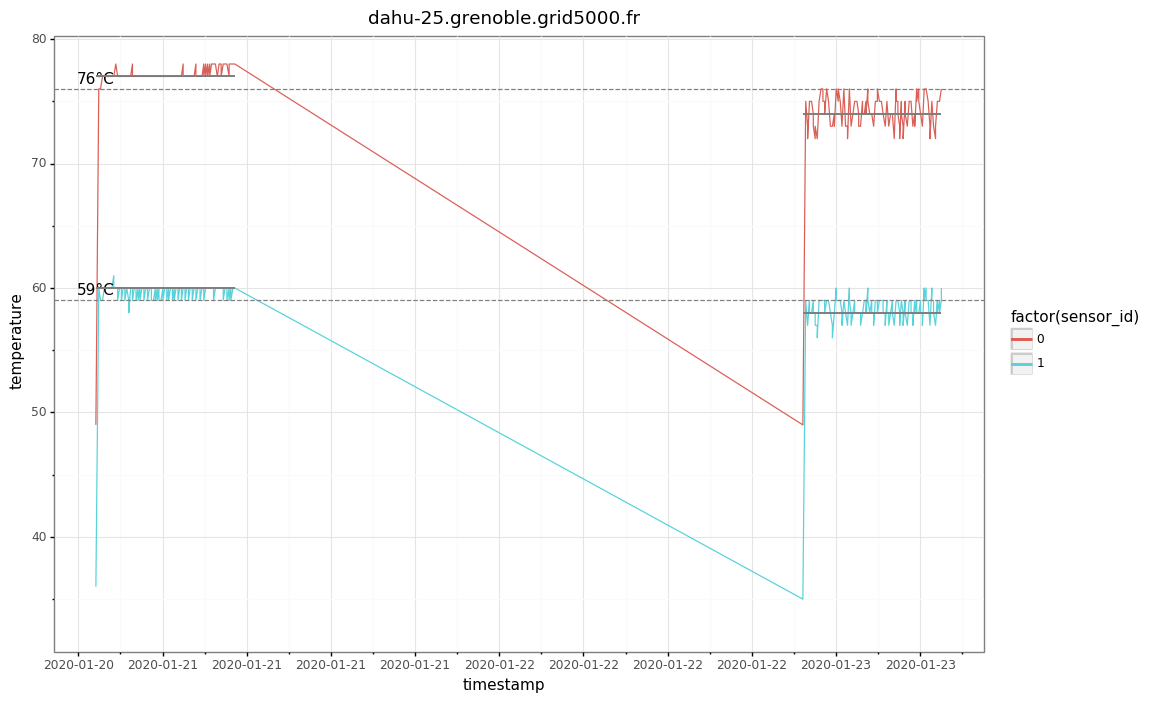

<ggplot: (8782799020471)>


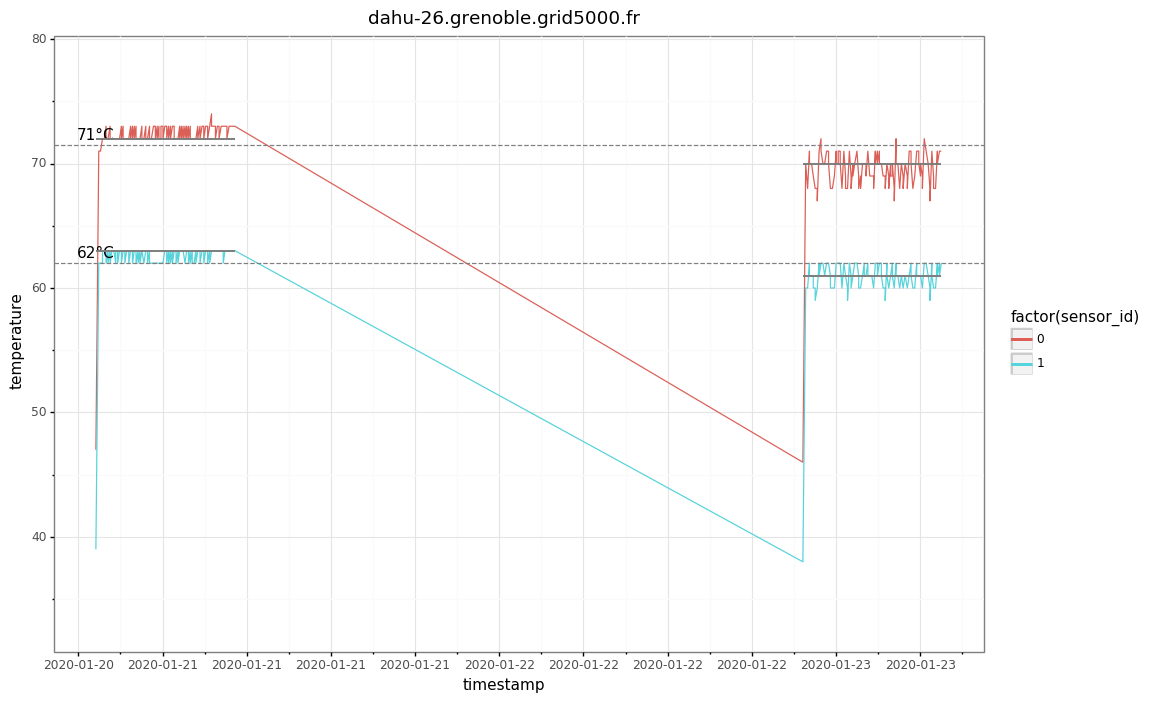

<ggplot: (-9223363254062870840)>


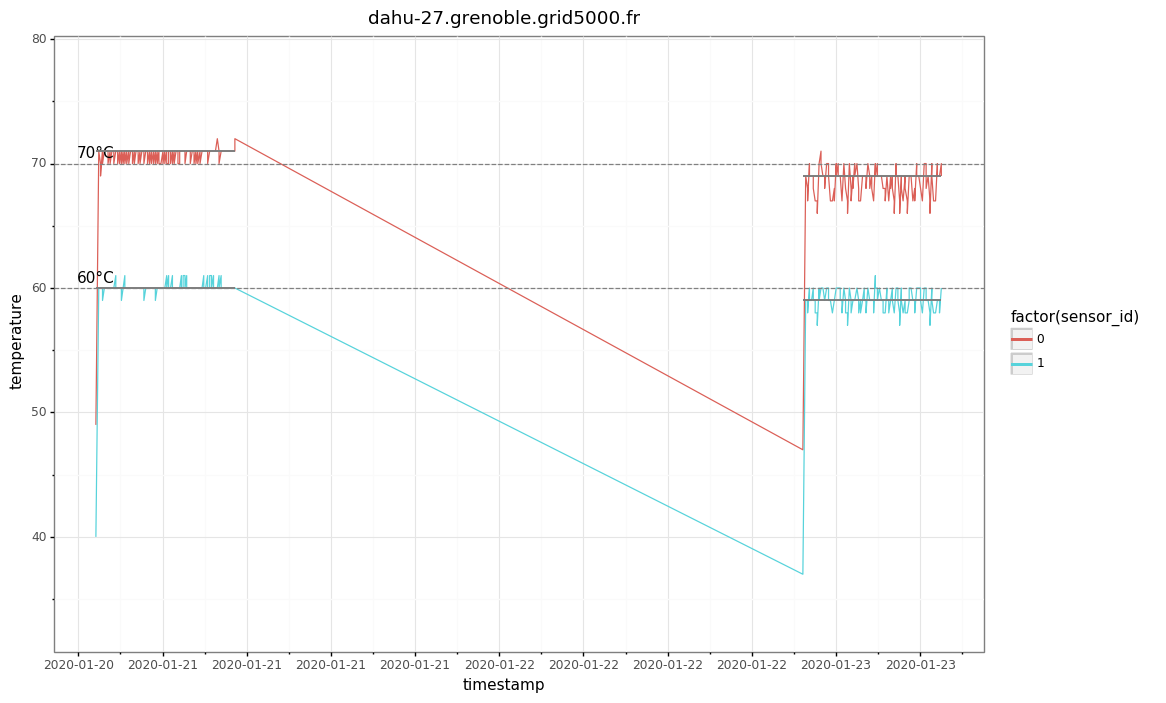

<ggplot: (8782792059326)>


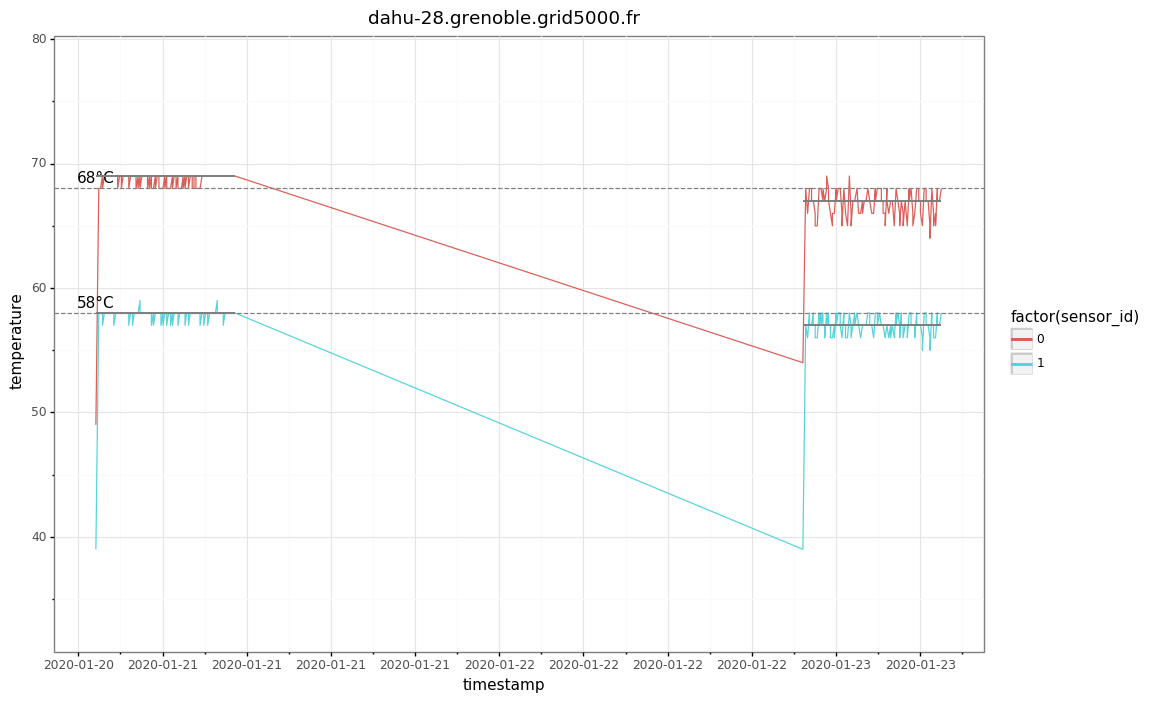

<ggplot: (-9223363254062495509)>


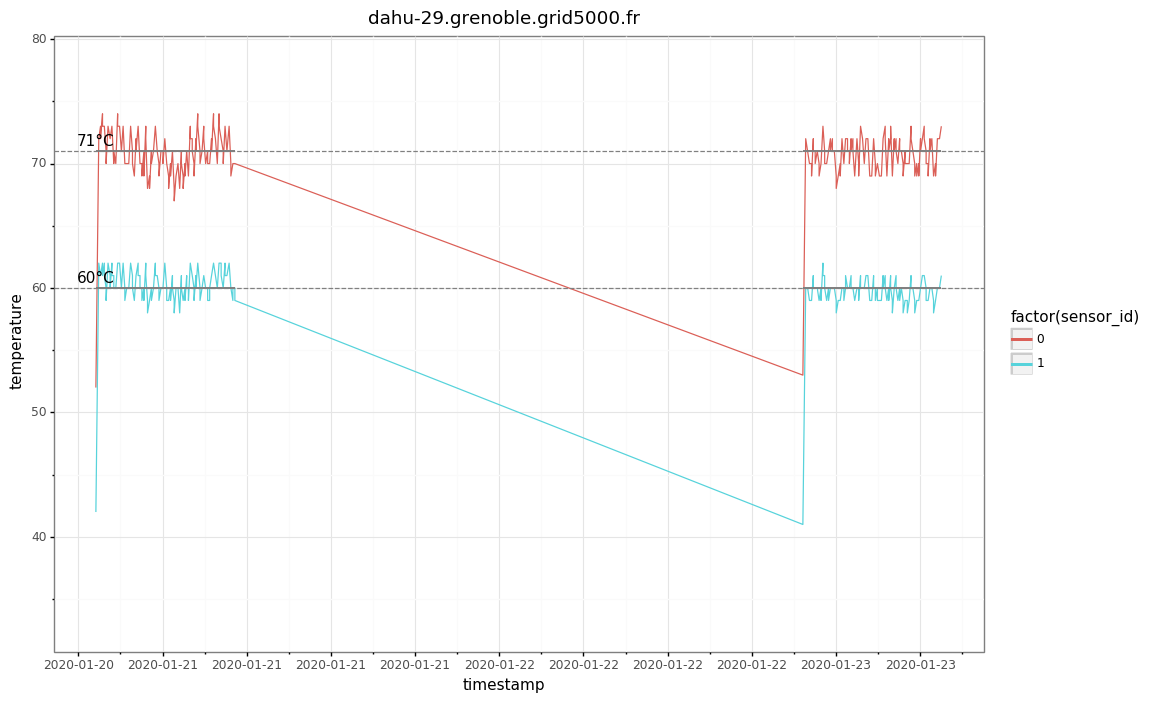

<ggplot: (8782792084786)>


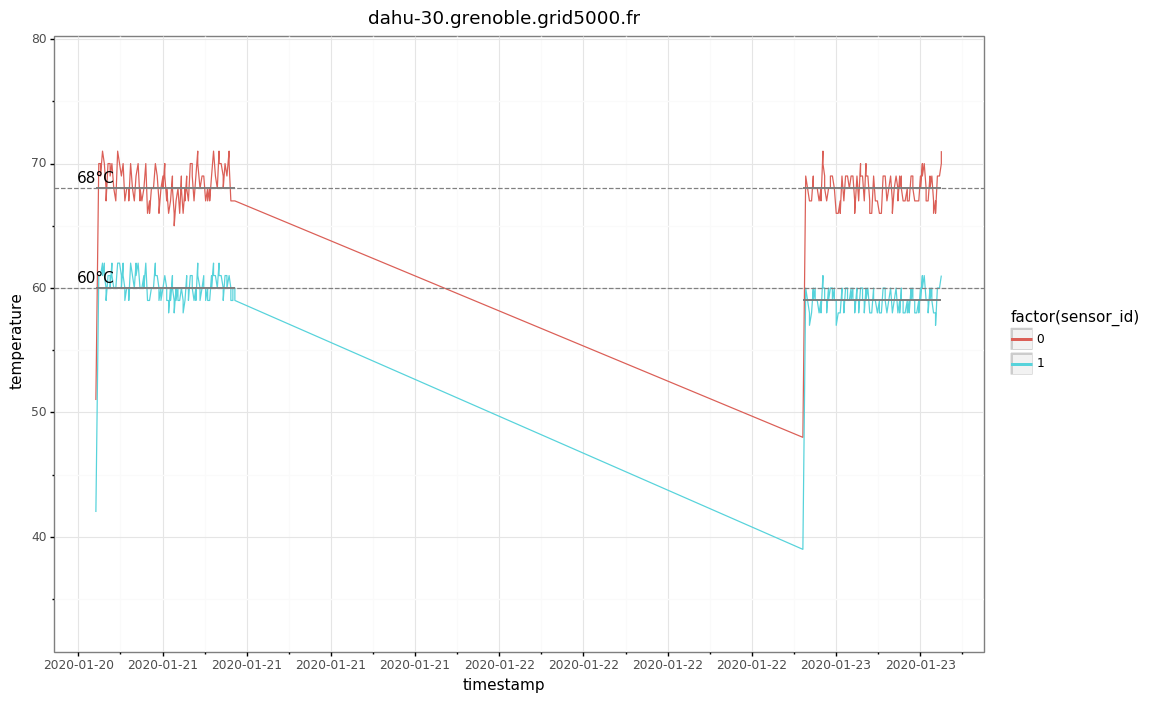

<ggplot: (8782798946522)>


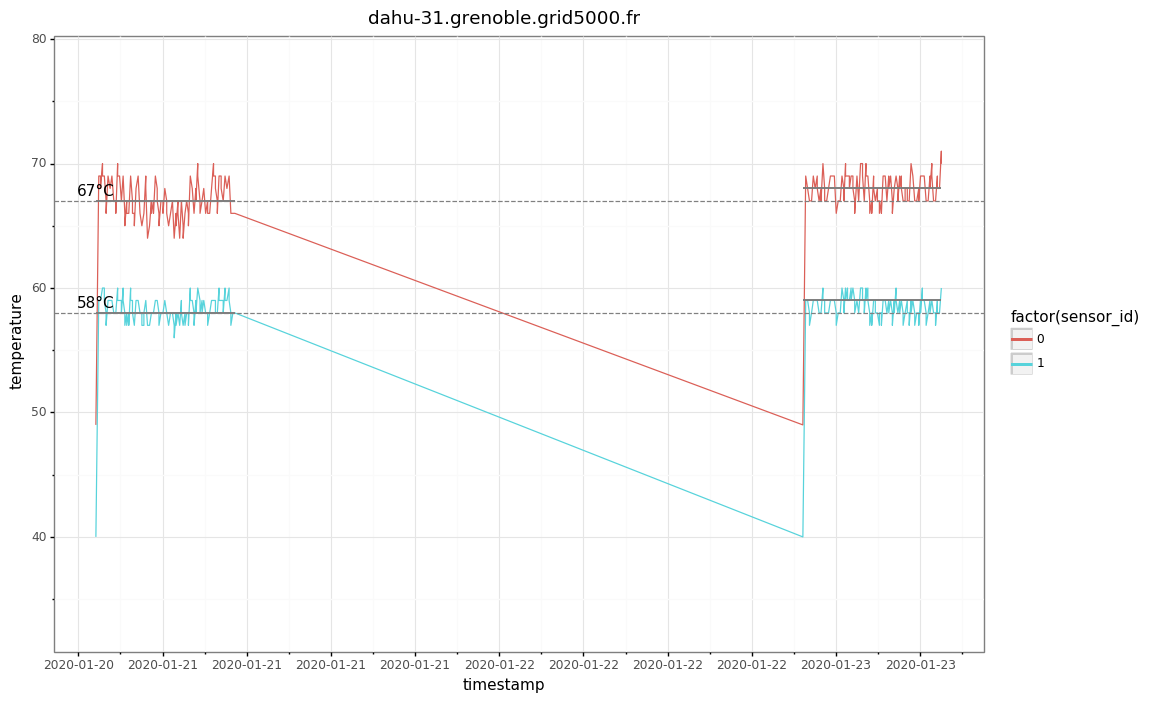

<ggplot: (8782792879515)>


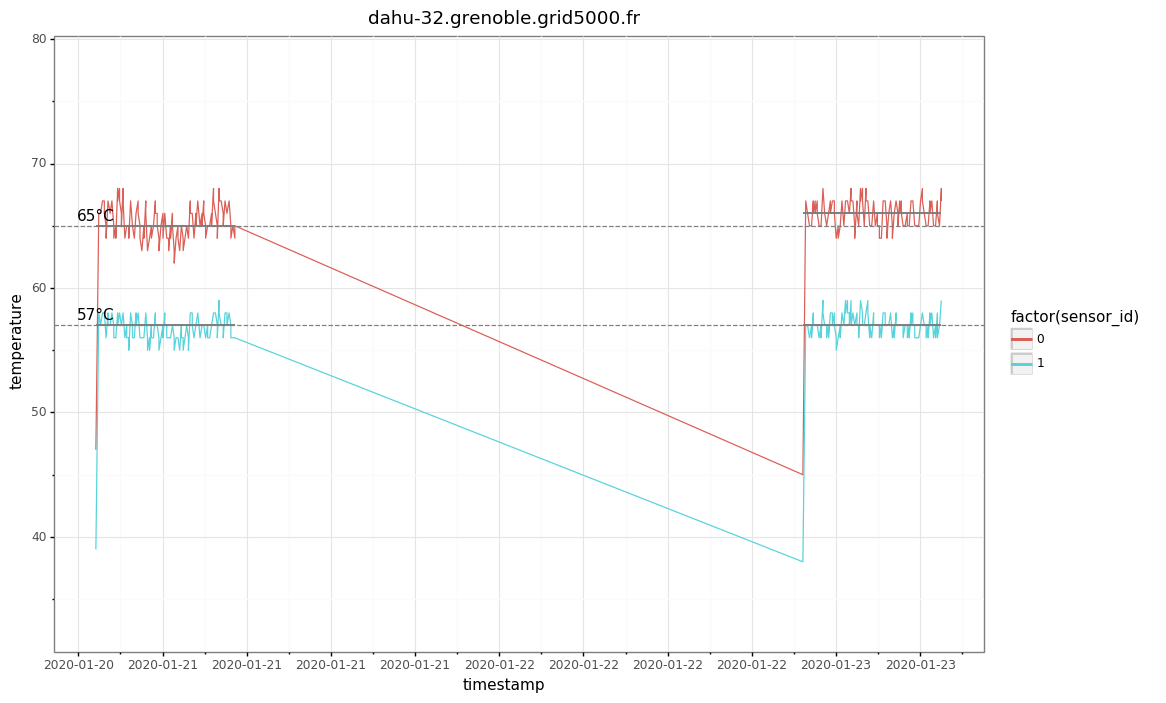

<ggplot: (-9223363254055779163)>


In [15]:
min_t = temperatures.temperature.min()
max_t = temperatures.temperature.max()
for node in sorted(temperatures.node.unique()):
    tmp = temperatures[temperatures.node == node]
    host = list(tmp.hostname.unique())[0]
    plot = ggplot(tmp, aes(x='timestamp', y='temperature', color='factor(sensor_id)'))
    plot = plot + theme_bw() + geom_line() + ggtitle(host)
    plot = plot + expand_limits(y=(min_t, max_t))
    for sensor_id in tmp.sensor_id.unique():
        tmp_s = tmp[tmp.sensor_id == sensor_id]
        med = tmp_s.temperature.median()
        plot = plot + geom_hline(yintercept=med, color='gray', linetype='dashed')
        plot = plot + annotate('text', label='%d°C' % med, x=tmp_s.timestamp.min(), y=med+0.8)
        for filename in sorted(tmp_s.filename.unique()):
            tmp_f = tmp_s[tmp_s.filename == filename]
            med_f = tmp_f.temperature.median()
            plot = plot + geom_segment(aes(x=tmp_f.timestamp.min(), xend=tmp_f.timestamp.max(), y=med_f, yend=med_f), color='gray', size=0.1)
    print(plot)

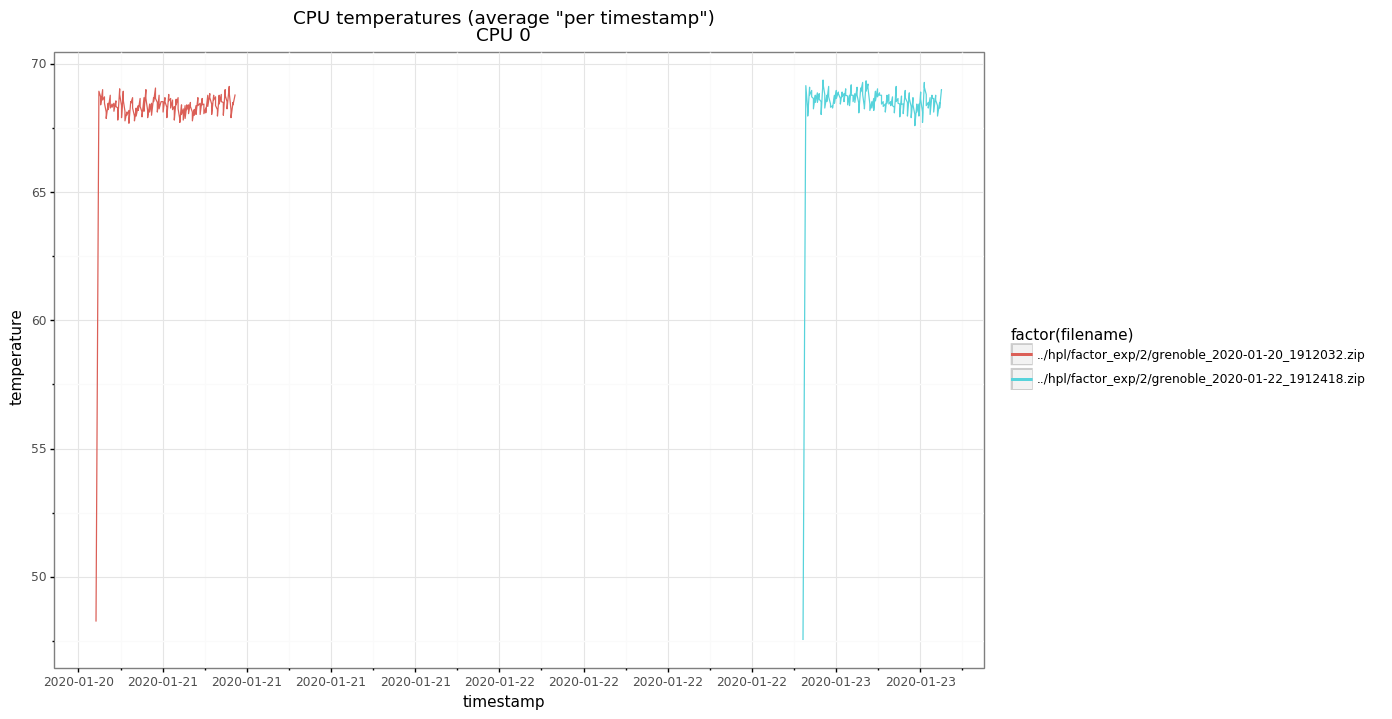

<ggplot: (-9223363254055729604)>


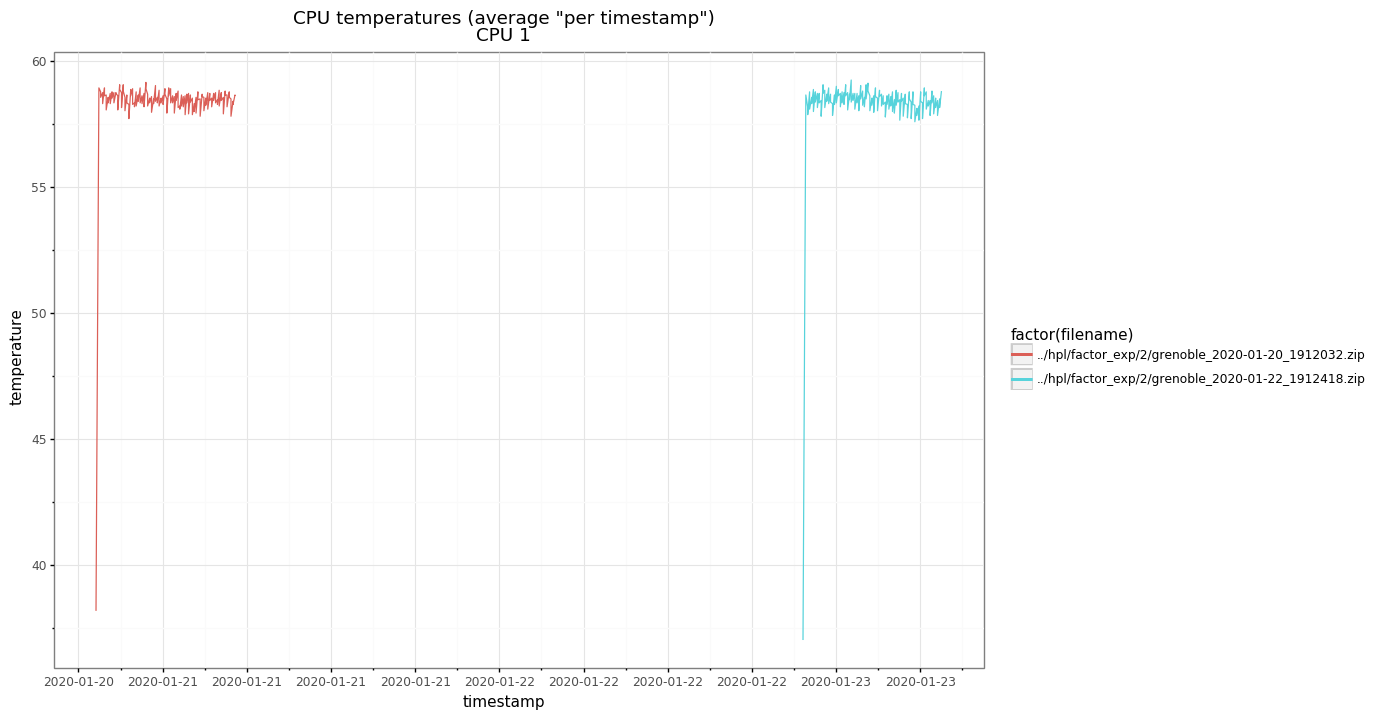

<ggplot: (8782792242899)>


In [16]:
temperatures['epoch'] = pandas.to_timedelta(temperatures.timestamp).dt.total_seconds()
tmp = temperatures.groupby(['index', 'sensor_id', 'filename'])[['epoch', 'temperature']].mean().reset_index()
tmp['timestamp'] = pandas.to_datetime(tmp['epoch'], unit='s')
for sensor_id in tmp.sensor_id.unique():
    plot = ggplot(tmp[tmp.sensor_id == sensor_id], aes(x='timestamp', y='temperature', color='factor(filename)'))
    plot = plot + geom_line() + theme_bw()
    plot = plot + ggtitle('CPU temperatures (average "per timestamp")\nCPU %d' % sensor_id)
    print(plot)

### Comparing the simulation with the real execution - ANOVA

In [17]:
my_anova(dfreal, factors, 'gflops').sort_values(by='F', ascending=False)

gflops ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(block_size),1.095511e+08,1.0,1443.207538,1.073314e-64,***
C(depth),3.500694e+07,1.0,461.175479,5.816488e-41,***
C(bcast),7.399588e+07,5.0,194.961814,1.155579e-52,***
C(swap):C(depth),1.709311e+07,2.0,112.590820,3.038738e-27,***
C(swap):C(bcast),4.054444e+07,10.0,53.412552,2.062435e-37,***
C(swap),3.063750e+06,2.0,20.180658,3.497565e-08,***
C(bcast):C(depth),5.327847e+06,5.0,14.037629,1.372884e-10,***
C(depth):C(block_size),2.102500e+04,1.0,0.276980,5.997569e-01,
C(bcast):C(block_size),9.786389e+04,5.0,0.257848,9.350135e-01,
C(swap):C(block_size),1.682222e+04,2.0,0.110807,8.952126e-01,


In [18]:
my_anova(dfsim, factors, 'gflops').sort_values(by='F', ascending=False)

gflops ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(block_size),1.174789e+08,1.0,185.617220,5.420966e-16,***
C(depth),3.817923e+07,1.0,60.323372,2.766254e-09,***
C(swap):C(depth),4.351902e+07,2.0,34.380128,3.645572e-09,***
C(bcast),3.851421e+07,5.0,12.170526,5.205518e-07,***
C(swap):C(bcast),3.597815e+07,10.0,5.684564,4.139750e-05,***
C(bcast):C(depth),8.249307e+06,5.0,2.606789,4.069230e-02,*
C(swap),1.520336e+06,2.0,1.201069,3.123315e-01,
C(bcast):C(block_size),9.799736e+05,5.0,0.309673,9.039935e-01,
C(swap):C(block_size),2.797861e+05,2.0,0.221032,8.027422e-01,
C(depth):C(block_size),6.540139e+04,1.0,0.103335,7.496732e-01,


### Comparing the simulation with the real execution - graphically

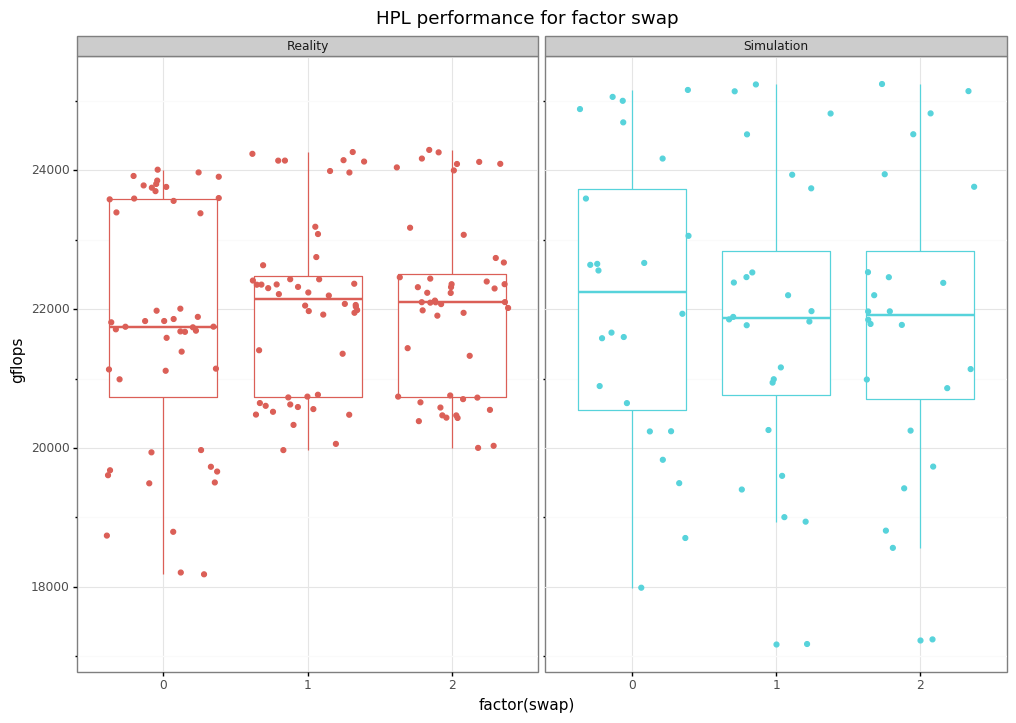

<ggplot: (-9223363254062769983)>


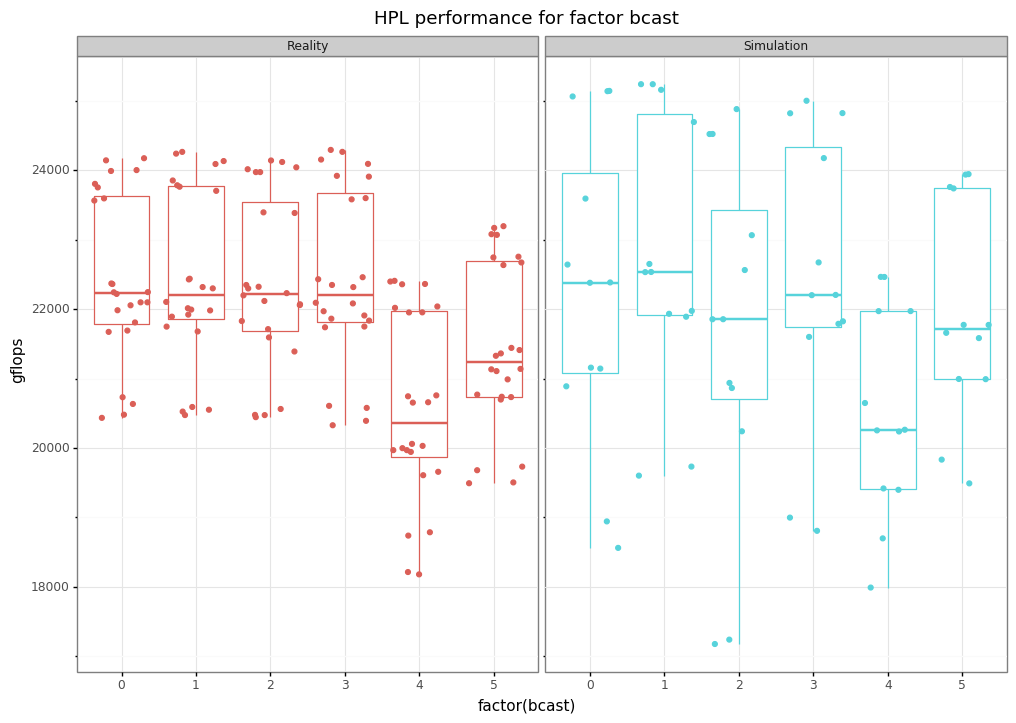

<ggplot: (-9223363254063027140)>


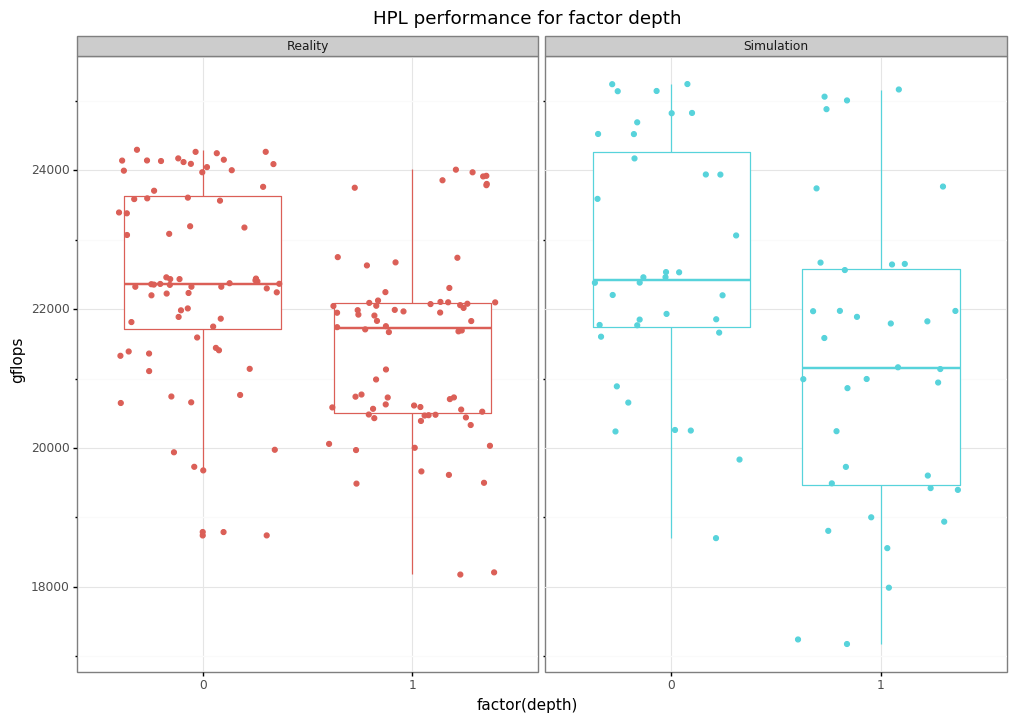

<ggplot: (8782792078014)>


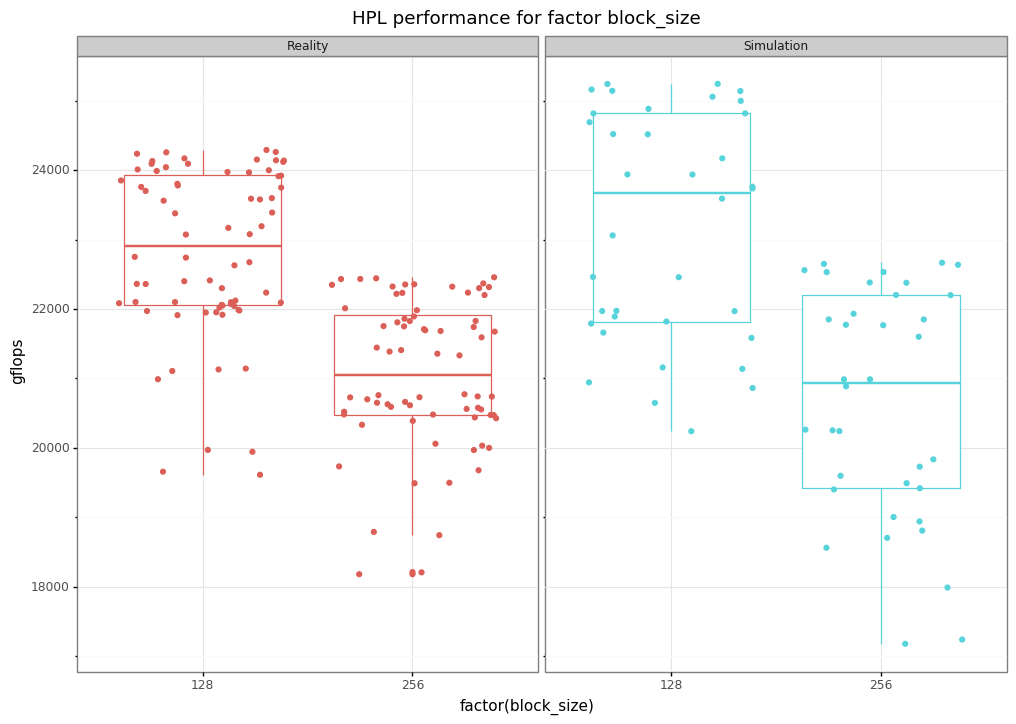

<ggplot: (8782792524264)>


In [19]:
for fact in factors:
    plot = ggplot(df, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none') + ggtitle('HPL performance for factor %s' % fact)
    plot = plot + geom_jitter()
    print(plot)

### Choosing iteratively the best combination (based on the simulation)

In [20]:
tmp = df[factors + ['gflops', 'mode']]
my_anova(tmp[tmp['mode'] == 'Simulation'], factors, 'gflops').sort_values(by='F', ascending=False)

gflops ~ (C(swap) + C(bcast) + C(depth) + C(block_size))**2


,sum_sq,df,F,PR(>F),stars
C(block_size),1.174789e+08,1.0,185.617220,5.420966e-16,***
C(depth),3.817923e+07,1.0,60.323372,2.766254e-09,***
C(swap):C(depth),4.351902e+07,2.0,34.380128,3.645572e-09,***
C(bcast),3.851421e+07,5.0,12.170526,5.205518e-07,***
C(swap):C(bcast),3.597815e+07,10.0,5.684564,4.139750e-05,***
C(bcast):C(depth),8.249307e+06,5.0,2.606789,4.069230e-02,*
C(swap),1.520336e+06,2.0,1.201069,3.123315e-01,
C(bcast):C(block_size),9.799736e+05,5.0,0.309673,9.039935e-01,
C(swap):C(block_size),2.797861e+05,2.0,0.221032,8.027422e-01,
C(depth):C(block_size),6.540139e+04,1.0,0.103335,7.496732e-01,


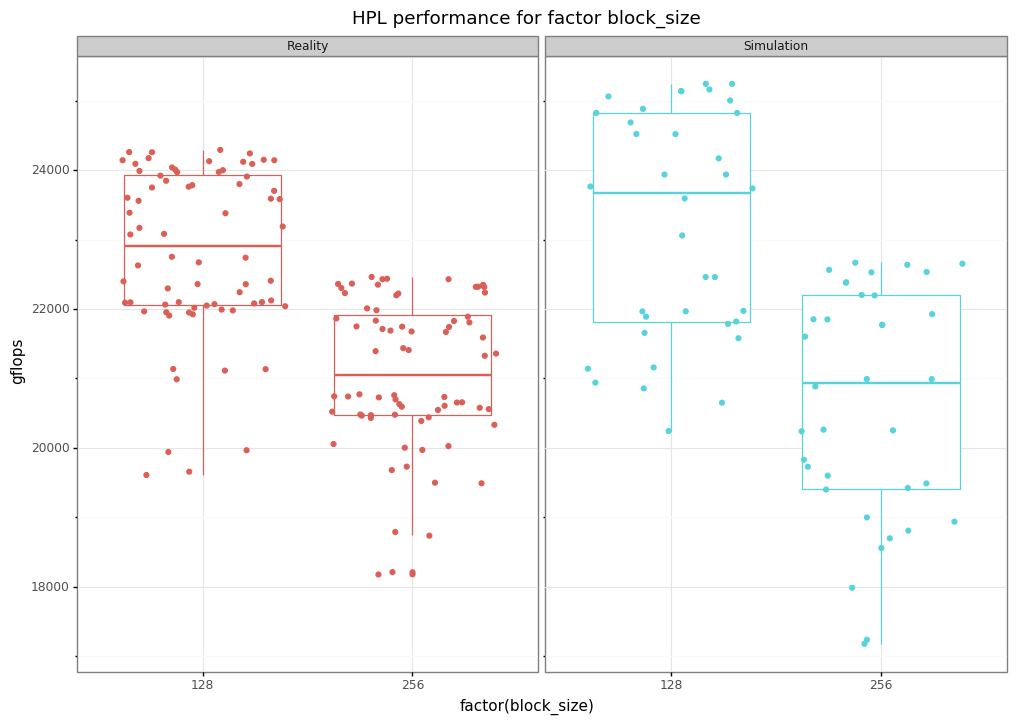

<ggplot: (-9223363254062871036)>

In [21]:
fact = 'block_size'
plot = ggplot(tmp, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none')
plot = plot + geom_jitter() + ggtitle('HPL performance for factor %s' % fact)
plot

In [22]:
tmp = tmp[tmp.block_size == 128]
my_anova(tmp[tmp['mode'] == 'Simulation'], factors, 'gflops').sort_values(by='F', ascending=False)

gflops ~ (C(swap) + C(bcast) + C(depth))**2


,sum_sq,df,F,PR(>F),stars
C(depth),1.754214e+07,1.0,17.465472,0.001890,**
C(swap):C(depth),1.945844e+07,2.0,9.686700,0.004573,**
C(bcast),2.153289e+07,5.0,4.287757,0.024097,*
C(swap):C(bcast),1.905958e+07,10.0,1.897629,0.163573,
C(bcast):C(depth),5.584981e+06,5.0,1.112115,0.412634,
C(swap),2.485500e+05,2.0,0.123732,0.884949,
Residual,1.004389e+07,10.0,NaN,NaN,


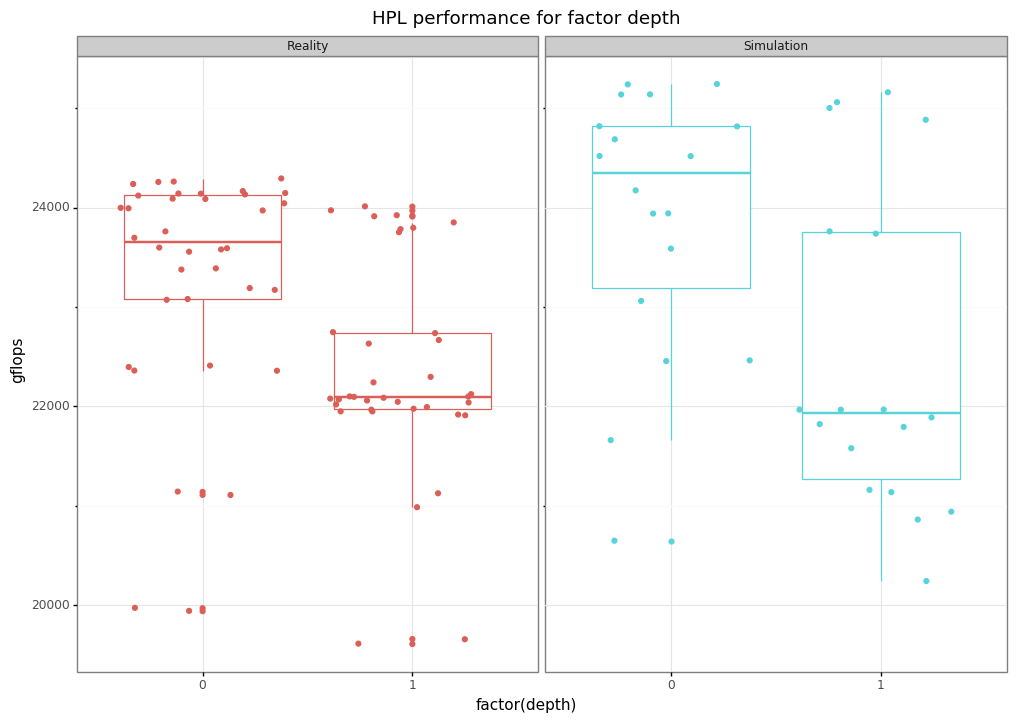

<ggplot: (-9223363254055685225)>

In [23]:
fact = 'depth'
plot = ggplot(tmp, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none')
plot = plot + geom_jitter() + ggtitle('HPL performance for factor %s' % fact)
plot

In [24]:
tmp = tmp[tmp.depth == 0]
my_anova(tmp[tmp['mode'] == 'Simulation'], factors, 'gflops', two_way=False).sort_values(by='F', ascending=False)

gflops ~ C(swap) + C(bcast)


,sum_sq,df,F,PR(>F),stars
C(bcast),2.120038e+07,5.0,28.242902,0.000014,***
C(swap),7.654444e+06,2.0,25.492910,0.000119,***
Residual,1.501289e+06,10.0,NaN,NaN,


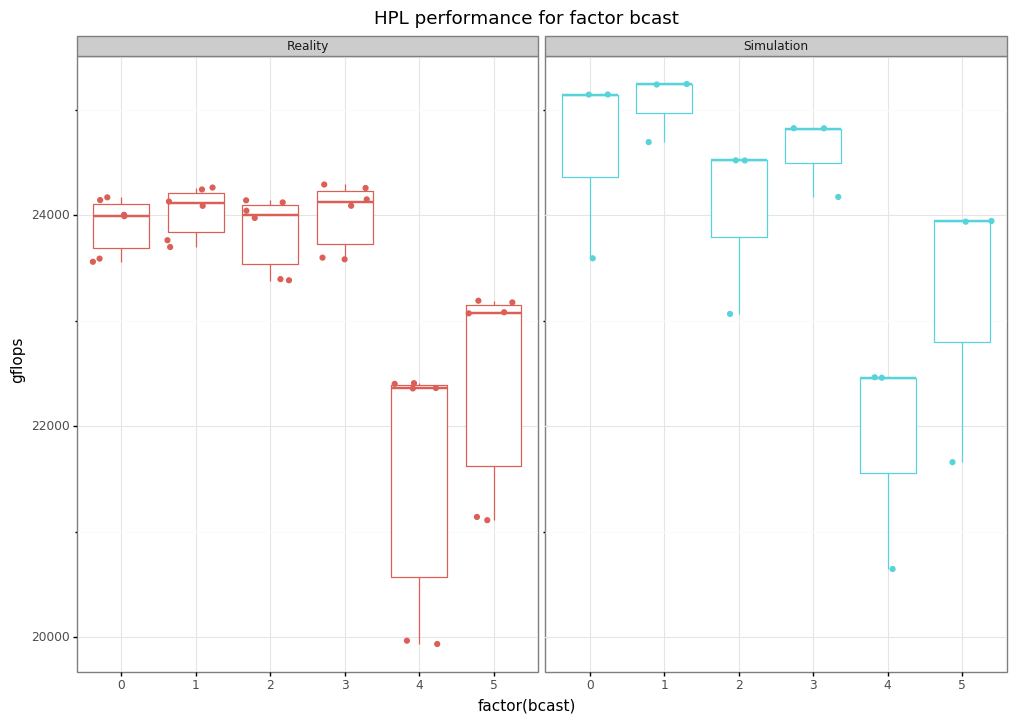

<ggplot: (8782791889500)>

In [25]:
fact = 'bcast'
plot = ggplot(tmp, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none')
plot = plot + geom_jitter() + ggtitle('HPL performance for factor %s' % fact)
plot

In [26]:
tmp = tmp[tmp.bcast.isin([0, 1])]
my_anova(tmp[tmp['mode'] == 'Simulation'], factors, 'gflops', two_way=False).sort_values(by='F', ascending=False)

gflops ~ C(swap) + C(bcast)


,sum_sq,df,F,PR(>F),stars
C(swap),1.470000e+06,2.0,4.41,0.184843,
C(bcast),2.816667e+05,1.0,1.69,0.323247,
Residual,3.333333e+05,2.0,NaN,NaN,


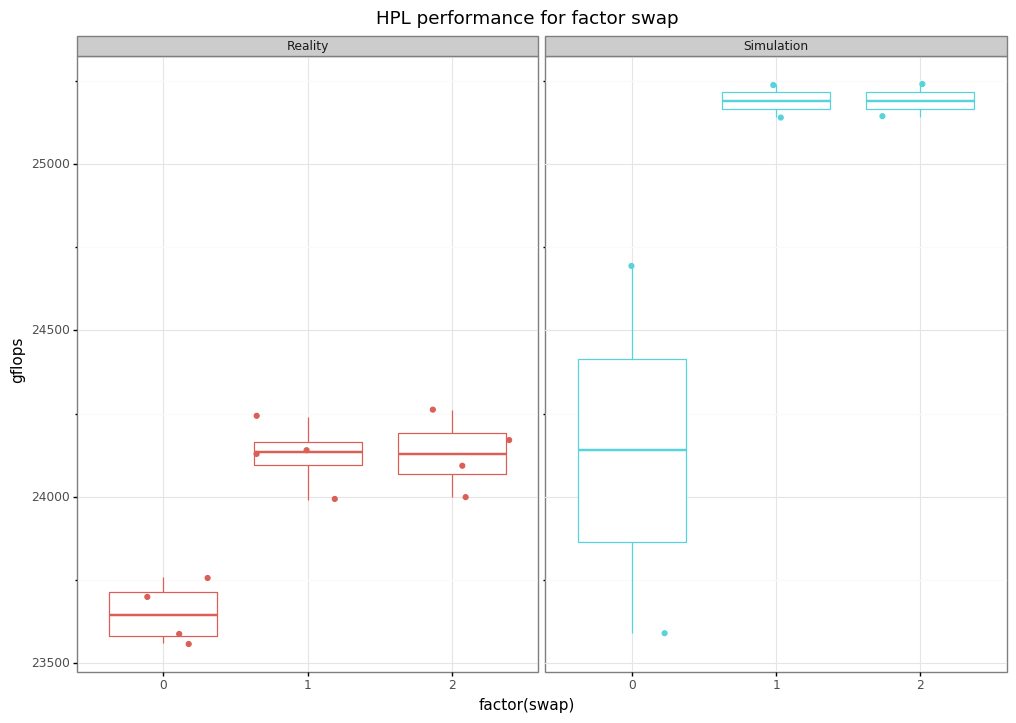

<ggplot: (8782798865072)>

In [27]:
fact = 'swap'
plot = ggplot(tmp, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none')
plot = plot + geom_jitter() + ggtitle('HPL performance for factor %s' % fact)
plot

In [28]:
tmp = tmp[tmp.swap.isin([1, 2])]
my_anova(tmp[tmp['mode'] == 'Simulation'], factors, 'gflops', two_way=False).sort_values(by='F', ascending=False)

gflops ~ C(swap) + C(bcast)


,sum_sq,df,F,PR(>F),stars
C(bcast),1.000000e+04,1.0,1.888947e+25,1.464773e-13,***
C(swap),0.000000e+00,1.0,0.000000e+00,1.000000e+00,
Residual,5.293956e-22,1.0,NaN,NaN,


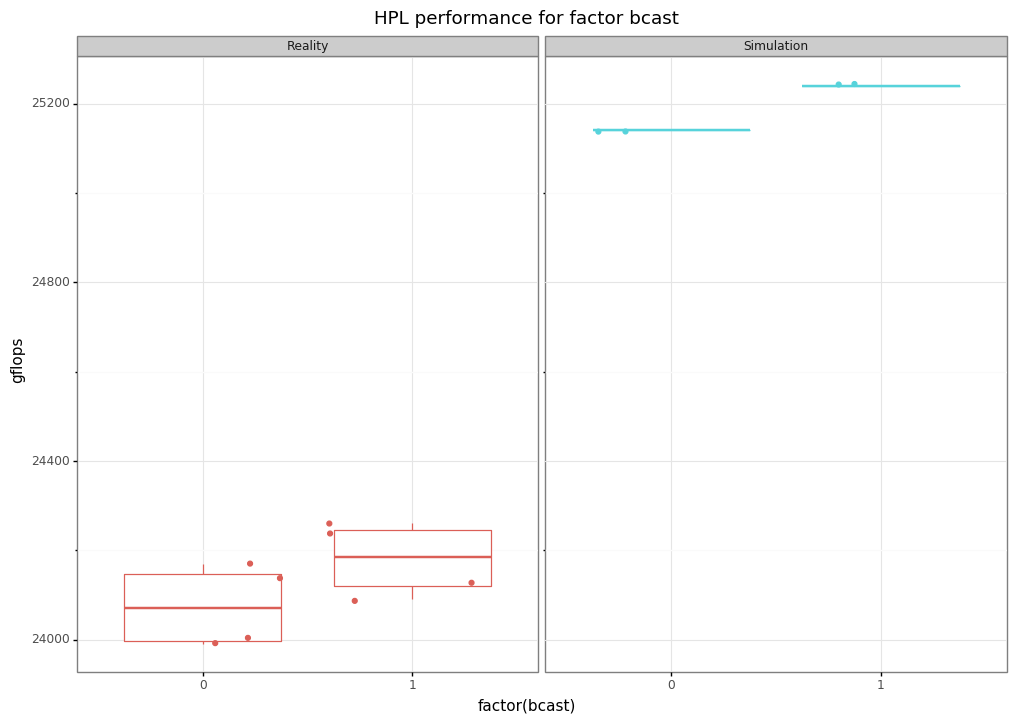

<ggplot: (-9223363254063090323)>

In [29]:
fact = 'bcast'
plot = ggplot(tmp, aes(x='factor(%s)' % fact, y='gflops', group=fact, color='mode')) + geom_boxplot() + theme_bw() + facet_wrap('mode') + theme(legend_position='none')
plot = plot + geom_jitter() + ggtitle('HPL performance for factor %s' % fact)
plot

In [30]:
tmp = tmp[tmp.bcast == 1]

In [31]:
tmp[tmp['mode'] == 'Simulation'].sort_values(by='gflops', ascending=False)

,swap,bcast,depth,block_size,gflops,mode
0,1,1,0,128,25240.0,Simulation
5,2,1,0,128,25240.0,Simulation


In [32]:
tmp[tmp['mode'] == 'Reality'].sort_values(by='gflops', ascending=False)

,swap,bcast,depth,block_size,gflops,mode
50,2,1,0,128,24260.0,Reality
40,1,1,0,128,24240.0,Reality
46,1,1,0,128,24130.0,Reality
43,2,1,0,128,24090.0,Reality


In [33]:
tmp[tmp['mode'] == 'Reality']['gflops'].describe()

count        4.000000
mean     24180.000000
std         82.865353
min      24090.000000
25%      24120.000000
50%      24185.000000
75%      24245.000000
max      24260.000000
Name: gflops, dtype: float64

In [34]:
df[df['mode'] == 'Reality'].gflops.describe(percentiles=[.1, .25, .5, .75, .9])

count      144.000000
mean     21947.916667
std       1431.398101
min      18180.000000
10%      20039.000000
25%      20737.500000
50%      22030.000000
75%      22830.000000
90%      23997.000000
max      24290.000000
Name: gflops, dtype: float64

In [35]:
df[df['mode'] == 'Reality'][factors + ['time', 'gflops']].sort_values(by='gflops', ascending=False).head(n=5)

,swap,bcast,depth,block_size,time,gflops
31,2,3,0,128,428.92,24290.0
50,2,1,0,128,429.34,24260.0
20,1,3,0,128,429.39,24260.0
40,1,1,0,128,429.82,24240.0
42,2,0,0,128,430.93,24170.0


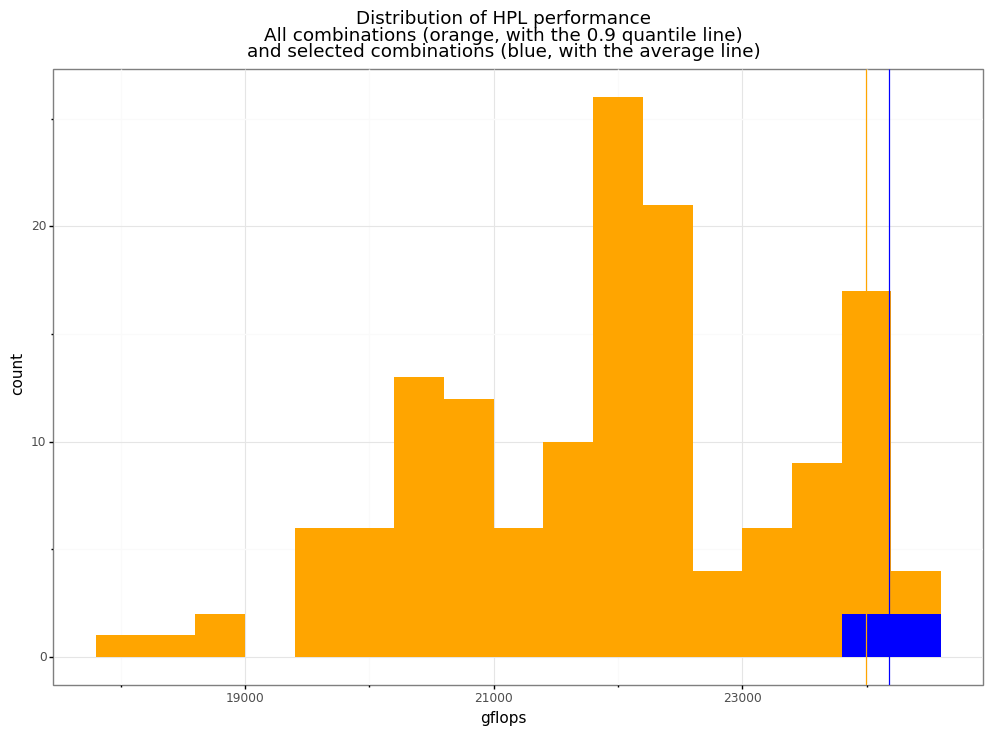

<ggplot: (8782798979939)>

In [36]:
tmpreal = tmp[tmp['mode'] == 'Reality']
plot = ggplot(aes(x='gflops')) + geom_histogram(dfreal, binwidth=400, fill='orange') + geom_histogram(tmpreal, binwidth=400, fill='blue') + theme_bw()
plot = plot + geom_vline(xintercept=tmpreal.gflops.mean(), color='blue') + geom_vline(xintercept=dfreal.gflops.quantile(0.9), color='orange')
plot = plot + ggtitle('Distribution of HPL performance\nAll combinations (orange, with the 0.9 quantile line)\nand selected combinations (blue, with the average line)')
plot